In [0]:
# Initialisation du notebook en important les différents modules nécessaires
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict

# Initialisation du client PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Importation des modules Python nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
import re
import time
from datetime import datetime,timedelta
import dateutil
import random as rd

from sklearn.cluster import KMeans,DBSCAN
from sklearn import metrics,preprocessing,mixture
from scipy.spatial.distance import cdist 
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering,MeanShift

import warnings
warnings.simplefilter('ignore')

Ce notebook est la seconde partie du projet 5 du parcours Data Scientist

Cette seconde partie consiste donc à trouver les groupes de clients à donner pour les campagnes de communication, et la manière dont ces groupes se constituent. Une fois cette caractérisation effectuée, il sera important de définir un protocole de maintenance, à savoir le délai dans lequel le clustering doit être effectué pour rester à jour.

<h3>Sommaire</h3>


1.   Segmentation de clients
2.   K-means

  1. Avec métacatégories
  2. Sans métacatégories
  3. Sans catégories de produits
3.   DBScan
4.   Gaussian mixture
5.   Protocole de maintenance



In [0]:
# Data import into the notebook, from Google Drive
link1 = "https://drive.google.com/open?id=1EdSl7e13Dg0FioNYWoRoquP19xZcwst0"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data_withmeta.csv')
datametacat = pd.read_csv('data_withmeta.csv', sep='\t')
print ("Dataset avec métacatégories importé")

link1 = "https://drive.google.com/open?id=1sV3qjS6GuOKqZ3RRnUYNQF4psfmTxHiL"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data_nometa.csv')
data = pd.read_csv('data_nometa.csv', sep='\t')
print ("Dataset sans métacatégories importé")


Dataset avec métacatégories importé
Dataset sans métacatégories importé


In [0]:
print (datametacat.columns)
print (data.columns)
datametacat.drop(['total_value', 'nb_orders'], axis=1, inplace=True)
data.drop(['total_value', 'nb_orders'], axis=1, inplace=True)


Index(['tot_metacat_construction', 'tot_metacat_electronics',
       'tot_metacat_fashion', 'tot_metacat_food_drink',
       'tot_metacat_furniture', 'tot_metacat_gifts',
       'tot_metacat_health_beauty', 'tot_metacat_home', 'tot_metacat_misc',
       'tot_metacat_sports_leisure', 'tot_metacat_supplies', 'total_value',
       'nb_orders', 'nb_products', 'last_order', 'review_score_mean',
       'total_value_log', 'nb_orders_log'],
      dtype='object')
Index(['total_value', 'nb_orders', 'nb_products', 'last_order',
       'review_score_mean', 'total_value_log', 'nb_orders_log',
       'product_category_name_english_agro_industry_and_commerce',
       'product_category_name_english_air_conditioning',
       'product_category_name_english_art',
       'product_category_name_english_arts_and_craftmanship',
       'product_category_name_english_audio',
       'product_category_name_english_auto',
       'product_category_name_english_baby',
       'product_category_name_english_bed_bath_

# Segmentation des clients

Pour commencer, il est nécessaire de segmenter nos données de clients pour chaque fichier ici importé, afin de préparer ces données au calcul du clustering par différents modèles détaillés dans les parties suivantes.

Tout d'abord, nous sélectionnons les clients pour lesquels toutes les variables ont été completées. Après standardisation, nous calculons ensuite une PCA afin de réduire le nombre de données, et transformons enfin le tout pour obtenir les données utilisables pour le clustering. 

Nous faisons de même pour le deuxième fichier.

In [0]:
print (len(datametacat))

X_with = datametacat
distortions = []
inertias = []

print (X_with.iloc[0, :])


92656
tot_metacat_construction        0.000000
tot_metacat_electronics         0.000000
tot_metacat_fashion             0.000000
tot_metacat_food_drink          0.000000
tot_metacat_furniture           1.000000
tot_metacat_gifts               0.000000
tot_metacat_health_beauty       0.000000
tot_metacat_home                0.000000
tot_metacat_misc                0.000000
tot_metacat_sports_leisure      0.000000
tot_metacat_supplies            0.000000
nb_products                     1.000000
last_order                    117.000000
review_score_mean               5.000000
total_value_log                 4.962145
nb_orders_log                   0.693147
Name: 0, dtype: float64


In [0]:
std_scale = preprocessing.StandardScaler().fit(X_with)
X_scaled_with = std_scale.transform(X_with)


Variance expliquée sur les données des clients avec métacatégories :  [0.14466627 0.21966504 0.29324964 0.36419292 0.43508326 0.50466998
 0.57223456 0.63771015 0.70247509 0.76702192 0.8309848  0.89126276
 0.94874173 0.98972345 0.99603013 1.        ]


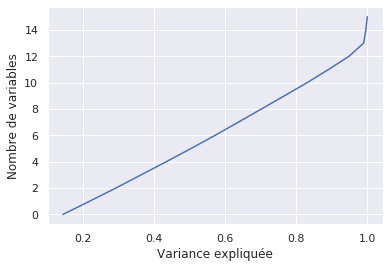

In [0]:
pca_with = PCA(n_components=None)
pca_with.fit(X_scaled_with)
print ("Variance expliquée sur les données des clients avec métacatégories : ",
       np.cumsum(pca_with.explained_variance_ratio_))

pcs_with = pca_with.components_

sns.set()
x_with = np.cumsum(pca_with.explained_variance_ratio_)
y_with = range(0, len(x_with))
sns.set()
plt.plot(x_with, y_with)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.show()


In [0]:
pca_final_with = PCA(n_components=0.9)
pca_final_with.fit(X_scaled_with)
X_projected_with = pca_final_with.transform(X_scaled_with)


In [0]:
print (len(data))

print (data.columns)
# Sample from our file, and initialization of our variables
X = data
distortions = []
inertias = []

print (X.iloc[0, :])


95075
Index(['nb_products', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log',
       'product_category_name_english_agro_industry_and_commerce',
       'product_category_name_english_air_conditioning',
       'product_category_name_english_art',
       'product_category_name_english_arts_and_craftmanship',
       'product_category_name_english_audio',
       'product_category_name_english_auto',
       'product_category_name_english_baby',
       'product_category_name_english_bed_bath_table',
       'product_category_name_english_books_general_interest',
       'product_category_name_english_books_imported',
       'product_category_name_english_books_technical',
       'product_category_name_english_cds_dvds_musicals',
       'product_category_name_english_christmas_supplies',
       'product_category_name_english_cine_photo',
       'product_category_name_english_computers',
       'product_category_name_english_computers_accessories',
       'product_cat

In [0]:
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


Variance expliquée sur les données de clients sans métacatégories :  [0.02975475 0.04583993 0.06123436 0.07581757 0.09017251 0.10444764
 0.1185504  0.13260485 0.14651086 0.16028369 0.17403797 0.1877278
 0.20134471 0.21494897 0.22853976 0.24207973 0.25556234 0.26903433
 0.28244642 0.29581236 0.30915986 0.32246858 0.33575115 0.34901306
 0.36226372 0.37551153 0.38875316 0.40198776 0.41521346 0.4284335
 0.44164733 0.45485799 0.46806244 0.48126226 0.49445829 0.50765355
 0.52084681 0.53403901 0.54723006 0.56042048 0.57361019 0.58679865
 0.59998514 0.61317062 0.62635475 0.63953712 0.65271684 0.66589569
 0.67907203 0.69224674 0.70541963 0.71859193 0.73176264 0.74493222
 0.75809973 0.77126614 0.78443162 0.79759602 0.81076014 0.82392367
 0.83708691 0.8502496  0.86341199 0.87657379 0.88973525 0.90289649
 0.91605696 0.92921694 0.94237608 0.95553466 0.96859051 0.98077263
 0.99138051 0.99849276 1.         1.        ]


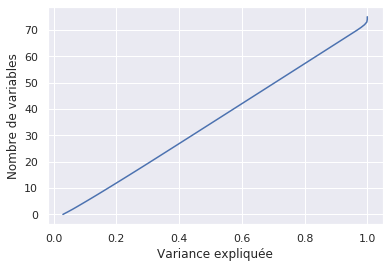

In [0]:
pca = PCA(n_components=None)
pca.fit(X_scaled)
print ("Variance expliquée sur les données de clients sans métacatégories : ",
       np.cumsum(pca.explained_variance_ratio_))

pcs = pca.components_

sns.set()
x = np.cumsum(pca.explained_variance_ratio_)
y = range(0, len(x))
sns.set()
plt.plot(x, y)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.show()


In [0]:
pca_final = PCA(n_components=0.9)
pca_final.fit(X_scaled)
X_projected = pca_final.transform(X_scaled)


Comme nous allons le voir par la suite (voir partie "K-means"), les catégories de produit ne semblent pas être intéressantes pour le clustering de la base de données client. Nous créons donc une troisième variable contenant la même base de données que précédemment, sans les catégories ou métacatégories de produits, sur laquelle nous effectuons la même préparation que précédemment. Nous pouvons d'ailleurs voir que les variables "nb_orders" et "nb_products" sont très fortement corrélées, nous n'en gardons du coup qu'une seule des deux, à savoir le nombre de commandes.

Variance expliquée sur les données de clients sans catégories :  [0.44173514 0.64434098 0.83882775 0.97674576 1.        ]


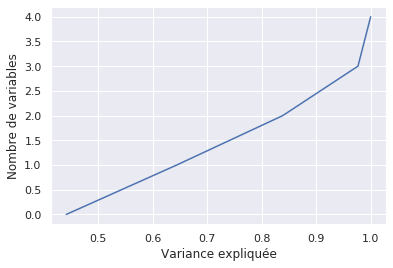

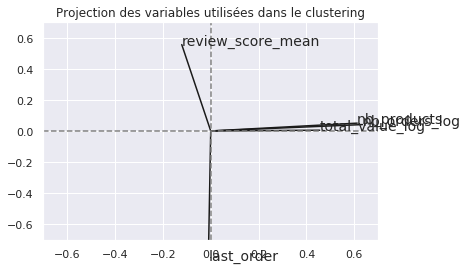

In [0]:
X_var = X[['total_value_log', 'nb_orders_log', 'nb_products', 'last_order',
           'review_score_mean']]
std_scale = preprocessing.StandardScaler().fit(X_var)
X_var_scaled = std_scale.transform(X_var)

pca_var = PCA(n_components=None)
pca_var.fit(X_var_scaled)
print ("Variance expliquée sur les données de clients sans catégories : ",
       np.cumsum(pca_var.explained_variance_ratio_))

pcs_var = pca_var.components_

sns.set()
x = np.cumsum(pca_var.explained_variance_ratio_)
y = range(0, len(x))
sns.set()
plt.plot(x, y)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.show()

pca_var_final = PCA(n_components=0.9)
pca_var_final.fit_transform(X_var_scaled)
X_var_projected = pca_var_final.transform(X_var_scaled)

sns.set()
for i, (x, y) in enumerate(zip(pcs_var[0, :], pcs_var[1, :])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, X_var.columns[i], fontsize='14')
# Show a horizontal line : y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
# Show a vertical line : x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
plt.title("Projection des variables utilisées dans le clustering")
plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
plt.show()


Variance expliquée sur les données de clients sans catégories :  [0.37819828 0.63083032 0.86951277 1.        ]


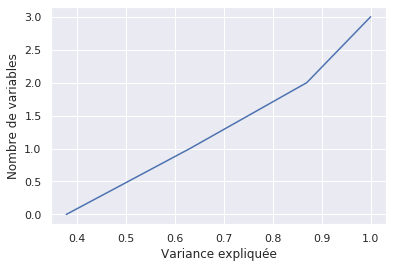

In [0]:
X_var = X[['nb_orders_log', 'total_value_log', 'last_order',
           'review_score_mean']]
std_scale = preprocessing.StandardScaler().fit(X_var)
X_var_scaled = std_scale.transform(X_var)

pca_var = PCA(n_components=None)
pca_var.fit(X_var_scaled)
print ("Variance expliquée sur les données de clients sans catégories : ",
       np.cumsum(pca_var.explained_variance_ratio_))

pcs_var = pca_var.components_

sns.set()
x = np.cumsum(pca_var.explained_variance_ratio_)
y = range(0, len(x))
sns.set()
plt.plot(x, y)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.show()

pca_var_final = PCA(n_components=0.9)
pca_var_final.fit(X_var_scaled)
X_var_projected = pca_var_final.transform(X_var_scaled)


# K-means

<h2>Avec métacatégories</h2>

Le première méthode de clustering que nous allons utiliser est celle des K-means, qui repose sur le positionnement de base aléatoire de centroïdes pour définir les groupes. Chacun des points de donnée va être positionné dans l'un des groupes selon sa proximité avec les centroïdes, centroïdes recalculés à chaque ajout de point dans les groupes. L'algorithme s'arrête lorsque les centroïdes ne bougent plus entre chaque itération.

Cet algorithme nécessite donc la connaissance du nombre de groupes souhaités dans notre clustering. Comme nous ne connaissons pas ce nombre, nous allons calculer la silhouette du K-means pour chaque nombre de groupes plausibles (entre 2 et le nombre de variables), c'est à dire étudier la qualité de la répartition dans les groupes. Nous calculons aussi l'inertie intergroupes : plus le nombre de groupes augmente, plus l'inertie diminue, mais finit par former un "coude" au niveau de la valeur la plus intéressante pour nous.

For n_clusters = 2 The average silhouette_score is : 0.26828945377997365
For n_clusters = 4 The average silhouette_score is : 0.15874488236006565
For n_clusters = 6 The average silhouette_score is : 0.2671173109566001
For n_clusters = 8 The average silhouette_score is : 0.3875773747557912
For n_clusters = 10 The average silhouette_score is : 0.4512639443210041
For n_clusters = 12 The average silhouette_score is : 0.49085553511419
For n_clusters = 14 The average silhouette_score is : 0.45021407148904563
For n_clusters = 16 The average silhouette_score is : 0.4540283956656354
For n_clusters = 18 The average silhouette_score is : 0.4124965325747357
For n_clusters = 20 The average silhouette_score is : 0.4101128332124484


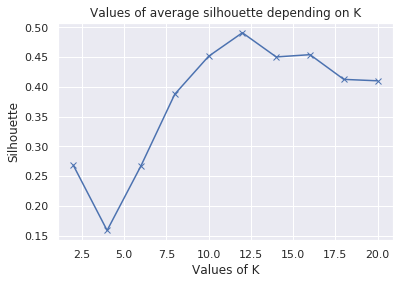

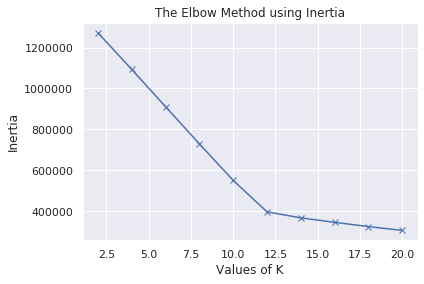

In [0]:
K = range(2, 21, 2)
distortions = []
inertias = []
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanModel.fit_predict(X_projected_with)
    distortions.append(sum(np.min(cdist(X_projected_with,
                                  kmeanModel.cluster_centers_, 'euclidean'),
                           axis=1)) / X_projected_with.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouette_avg = metrics.silhouette_score(X_projected_with, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", k, "The average silhouette_score is :",
          silhouette_avg)

sns.set()
plt.plot(K, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Values of average silhouette depending on K')
plt.show()

sns.set()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


For n_clusters = 20 The average silhouette_score is : 0.4101128332124484
For n_clusters = 22 The average silhouette_score is : 0.43519703746635957
For n_clusters = 24 The average silhouette_score is : 0.4339012394231679
For n_clusters = 26 The average silhouette_score is : 0.38017253892781344
For n_clusters = 28 The average silhouette_score is : 0.3908788843456021
For n_clusters = 30 The average silhouette_score is : 0.4081490977728629
For n_clusters = 32 The average silhouette_score is : 0.38056786344814053
For n_clusters = 34 The average silhouette_score is : 0.40560565219212036
For n_clusters = 36 The average silhouette_score is : 0.4078912876775824
For n_clusters = 38 The average silhouette_score is : 0.41085526644616854


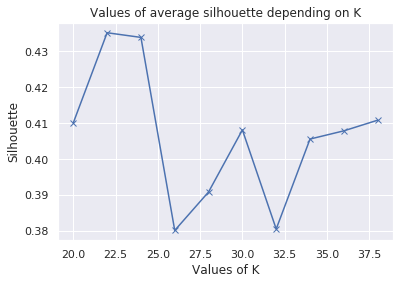

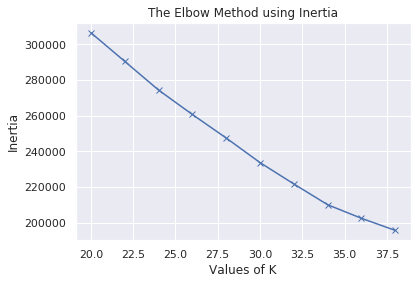

In [0]:
K = range(20, 40, 2)
distortions = []
inertias = []
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanModel.fit_predict(X_projected_with)
    distortions.append(sum(np.min(cdist(X_projected_with,
                                        kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) /
                       X_projected_with.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouette_avg = metrics.silhouette_score(X_projected_with, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", k, "The average silhouette_score is :",
          silhouette_avg)

sns.set()
plt.plot(K, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Values of average silhouette depending on K')
plt.show()

sns.set()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


Après avoir effectué tous les K-means avec les nombres de groupe pouvant nous intéresser, nous faisons des calculs plus centrés sur les valeurs de silhouettes les plus hautes. En effet, nous avons calculé des nombres de groupes pairs uniquement, donc centrer l'intervalles du nombre de groupes nous permet de calculer aussi les valeurs impaires. Ici, la meilleure qualité de clustering serait avec 12 groupes, ce qui est assez important.

For n_clusters = 10 The average silhouette_score is : 0.4512639443210041
For n_clusters = 11 The average silhouette_score is : 0.4854579998591691
For n_clusters = 12 The average silhouette_score is : 0.49085553511419
For n_clusters = 13 The average silhouette_score is : 0.45963761637482875
For n_clusters = 14 The average silhouette_score is : 0.45021407148904563
For n_clusters = 15 The average silhouette_score is : 0.4514441331552327
For n_clusters = 16 The average silhouette_score is : 0.4540283956656354
For n_clusters = 17 The average silhouette_score is : 0.455023898790686
For n_clusters = 18 The average silhouette_score is : 0.4124965325747357
For n_clusters = 19 The average silhouette_score is : 0.39813243810714977
For n_clusters = 20 The average silhouette_score is : 0.4101128332124484
For n_clusters = 21 The average silhouette_score is : 0.39682902762010913
For n_clusters = 22 The average silhouette_score is : 0.43519703746635957
For n_clusters = 23 The average silhouette_score 

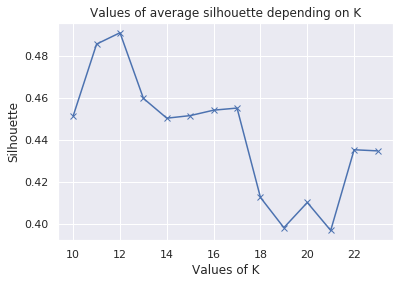

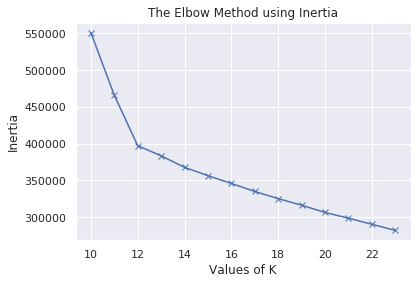

In [0]:
# Find more precisely the value of K around the best value
K = range(10, 24)
distortions = []
inertias = []
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanModel.fit_predict(X_projected_with)
    distortions.append(sum(np.min(cdist(X_projected_with,
                                        kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) /
                       X_projected_with.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouette_avg = metrics.silhouette_score(X_projected_with, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", k, "The average silhouette_score is :",
          silhouette_avg)

sns.set()
plt.plot(K, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Values of average silhouette depending on K')
plt.show()

sns.set()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


Cependant, si on étudie la répartition des différents clusters et leurs intervalles de valeurs pour chacune des variables, nous nous rendons compte que leur répartition ne doit réellement pas être optimale pour les données dont nous disposons.

Nombre de clusters :  12
Nombre de variables :  16


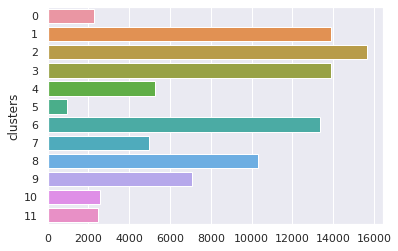

Int64Index([2, 3, 1, 6, 8, 9, 4, 7, 10, 11, 0, 5], dtype='int64', name='clusters') [15641 13886 13879 13338 10303  7093  5276  4954  2556  2480  2294   956]


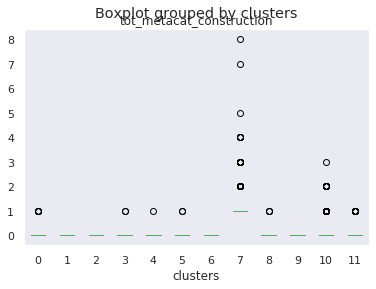

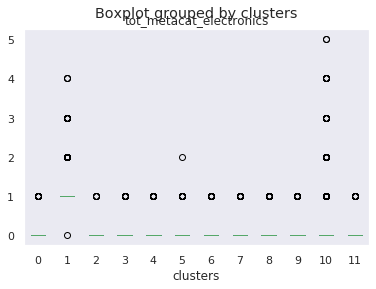

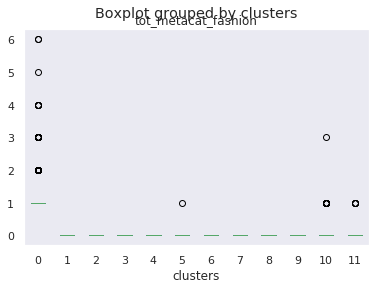

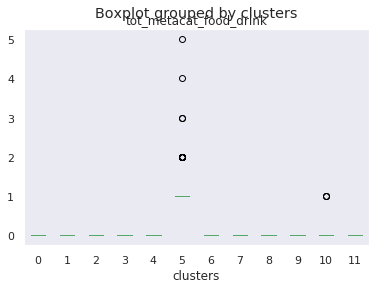

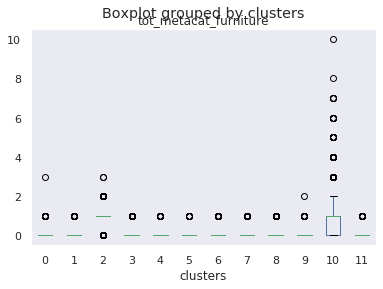

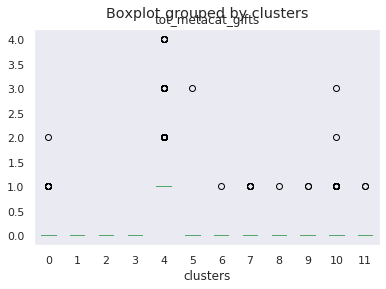

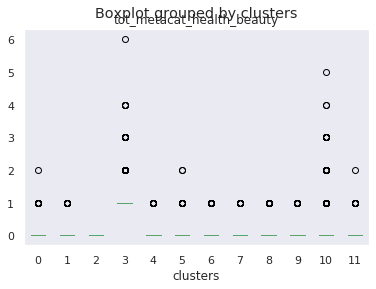

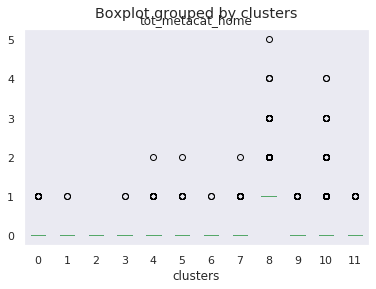

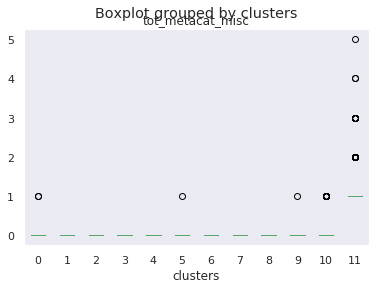

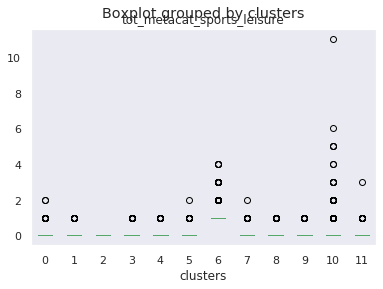

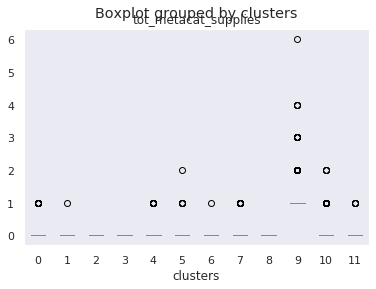

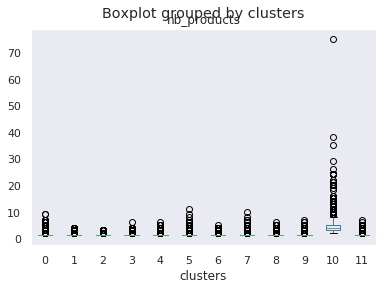

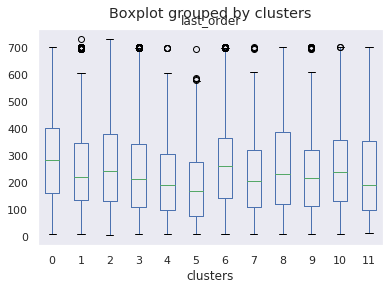

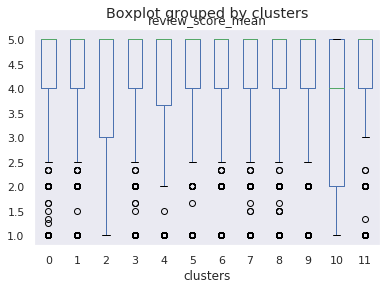

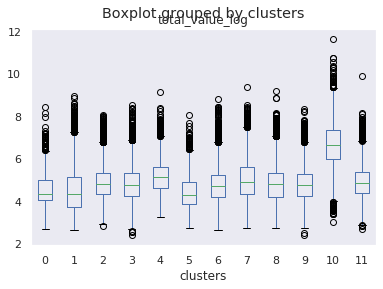

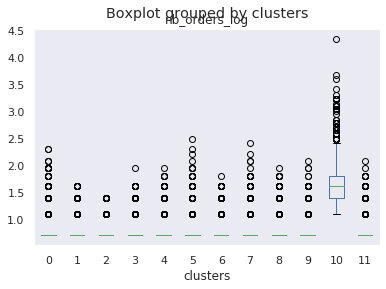

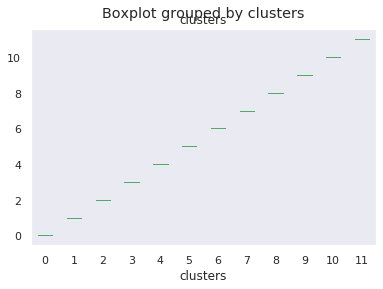

In [0]:
kmeans_with = KMeans(n_clusters=12, random_state=1).fit(X_projected_with)
kmeans_with.fit(X_projected_with)
y_kmeans_with = kmeans_with.predict(X_projected_with)
centers_with = kmeans_with.cluster_centers_
columns_with = X_with.columns

print ("Nombre de clusters : ", len(centers_with))
print ("Nombre de variables : ", len(columns_with))

X_with['clusters'] = y_kmeans_with

col = X_with.columns

sns.set()
clusterstotal = X_with.groupby(['clusters'])
countclusterstotal = clusterstotal['clusters'].count()
countclusterstotal = countclusterstotal.sort_values(ascending=False)
labels = countclusterstotal.index
sizes = countclusterstotal.values
'''
# Pairplot
sns.set()
sns.pairplot(X_with, height=5, hue='clusters')
plt.show()
'''
sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.show()

print (labels, sizes)

for c in col:
    sns.set()
    X_with.boxplot(by='clusters', column=[c], grid=False)
    plt.plot()


<h2>Sans métacatégories</h2>

Nous effectuons la même technique que précédemment pour définir la bonne valeur de nombre de groupes dans le cas de ce fichier avec beaucoup plus de variables.

For n_clusters = 2 The average silhouette_score is : 0.10932884564617219
For n_clusters = 4 The average silhouette_score is : 0.007348114444610943
For n_clusters = 6 The average silhouette_score is : 0.06504844912922776
For n_clusters = 8 The average silhouette_score is : 0.06698950427039649
For n_clusters = 10 The average silhouette_score is : 0.1296537708406054
For n_clusters = 12 The average silhouette_score is : 0.15197992556329137
For n_clusters = 14 The average silhouette_score is : 0.16599073302394068
For n_clusters = 16 The average silhouette_score is : 0.23875302729077488
For n_clusters = 18 The average silhouette_score is : 0.2840816327127551
For n_clusters = 20 The average silhouette_score is : 0.3185294748334619
For n_clusters = 22 The average silhouette_score is : 0.3180015118085563
For n_clusters = 24 The average silhouette_score is : 0.3506385465098948
For n_clusters = 26 The average silhouette_score is : 0.4109086731992432
For n_clusters = 28 The average silhouette_scor

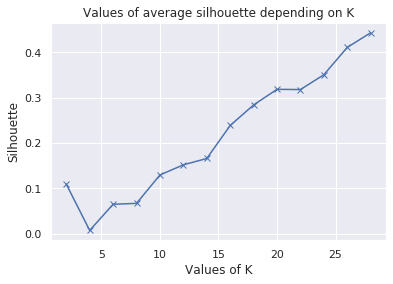

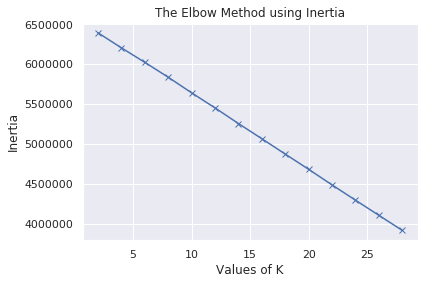

In [0]:
K = range(2, 30, 2)
distortions = []
inertias = []
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanModel.fit_predict(X_projected)
    distortions.append(sum(np.min(cdist(X_projected,
                                        kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) /
                       X_projected.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouette_avg = metrics.silhouette_score(X_projected, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", k, "The average silhouette_score is :",
          silhouette_avg)

sns.set()
plt.plot(K, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Values of average silhouette depending on K')
plt.show()

sns.set()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


For n_clusters = 30 The average silhouette_score is : 0.44671914919783595
For n_clusters = 32 The average silhouette_score is : 0.45994307625047437
For n_clusters = 34 The average silhouette_score is : 0.4923259207922034
For n_clusters = 36 The average silhouette_score is : 0.4922772594607274
For n_clusters = 38 The average silhouette_score is : 0.5017387581472073
For n_clusters = 40 The average silhouette_score is : 0.5155387378815816
For n_clusters = 42 The average silhouette_score is : 0.5420379179167967
For n_clusters = 44 The average silhouette_score is : 0.5564036406705147
For n_clusters = 46 The average silhouette_score is : 0.5684431822270817
For n_clusters = 48 The average silhouette_score is : 0.5844199204302635
For n_clusters = 50 The average silhouette_score is : 0.5926630175753829
For n_clusters = 52 The average silhouette_score is : 0.6066720535278838
For n_clusters = 54 The average silhouette_score is : 0.6095784833314263
For n_clusters = 56 The average silhouette_score 

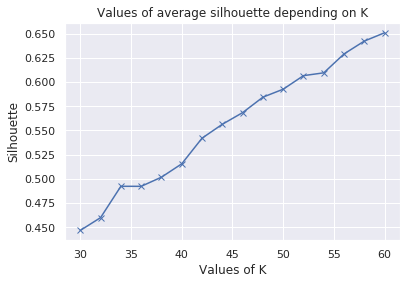

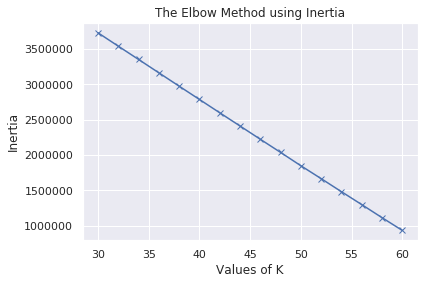

In [0]:
K = range(30, 61, 2)
distortions = []
inertias = []
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanModel.fit_predict(X_projected)
    distortions.append(sum(np.min(cdist(X_projected,
                                        kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) /
                       X_projected.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouette_avg = metrics.silhouette_score(X_projected, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", k, "The average silhouette_score is :",
          silhouette_avg)

sns.set()
plt.plot(K, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Values of average silhouette depending on K')
plt.show()

sns.set()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


For n_clusters = 60 The average silhouette_score is : 0.6509981392889367
For n_clusters = 62 The average silhouette_score is : 0.6689897268210431
For n_clusters = 64 The average silhouette_score is : 0.6832629931432278
For n_clusters = 66 The average silhouette_score is : 0.7105714394301366
For n_clusters = 68 The average silhouette_score is : 0.7178973413714332
For n_clusters = 70 The average silhouette_score is : 0.7033415366214184
For n_clusters = 72 The average silhouette_score is : 0.6973338152678439
For n_clusters = 74 The average silhouette_score is : 0.6728605110722197
For n_clusters = 76 The average silhouette_score is : 0.6725732518588433
For n_clusters = 78 The average silhouette_score is : 0.6562446094770027
For n_clusters = 80 The average silhouette_score is : 0.6432072032277166


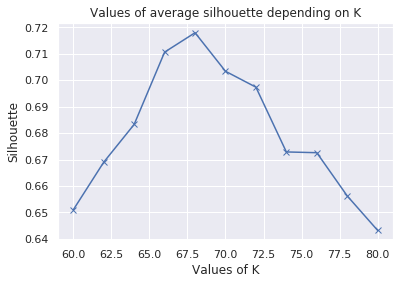

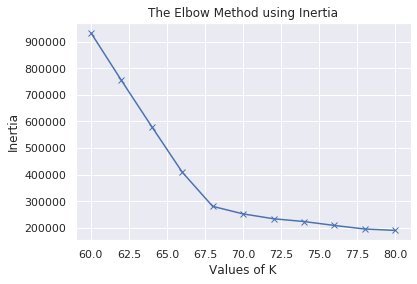

In [0]:
K = range(60, 81, 2)
distortions = []
inertias = []
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanModel.fit_predict(X_projected)
    distortions.append(sum(np.min(cdist(X_projected,
                                  kmeanModel.cluster_centers_, 'euclidean'),
                                  axis=1)) / X_projected.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouette_avg = metrics.silhouette_score(X_projected, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", k, "The average silhouette_score is :",
          silhouette_avg)

sns.set()
plt.plot(K, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Values of average silhouette depending on K')
plt.show()

sns.set()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


Nous obtenons aussi la meilleure qualité possible avec 68 groupes, ce qui est beaucoup trop pour des campagnes de communication. De plus, comme c'est également le cas sur le premier fichier, nous pouvons voir que les catégories (ou métacatgories) de produits ne semblent pas permettre la différenciation en différents groupes de clients.

Nombre de clusters :  68
Nombre de variables :  76


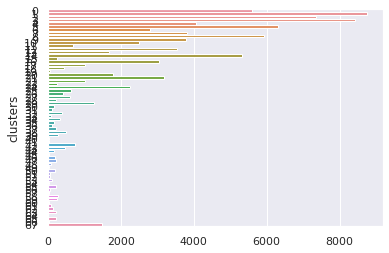

Int64Index([ 1,  3,  2,  5,  8,  0, 14,  4,  7,  9, 12, 21, 16,  6, 10, 24, 20,
            13, 67, 29, 17, 22, 42, 11, 25, 27, 38, 43, 18, 26, 32, 34, 58, 39,
            59, 23, 15, 63, 37, 28, 55, 65, 47, 50, 46, 35, 44, 30, 62, 31, 36,
            53, 33, 61, 48, 56, 51, 52, 19, 54, 45, 40, 41, 49, 66, 60, 57,
            64],
           dtype='int64', name='clusters') [8735 8413 7348 6318 5935 5606 5316 4060 3812 3799 3537 3186 3051 2812
 2495 2246 1776 1675 1478 1257 1034 1017  741  703  626  623  504  484
  434  414  393  346  289  279  253  248  247  241  238  232  229  225
  217  196  191  180  176  166  139  128  121  110   97   91   78   75
   65   58   52   39   39   38   38   29   27   26   23   21]


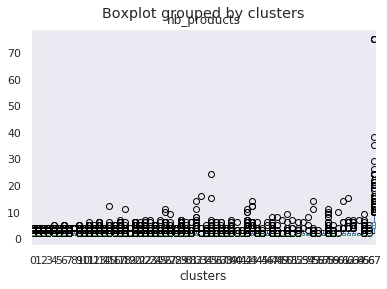

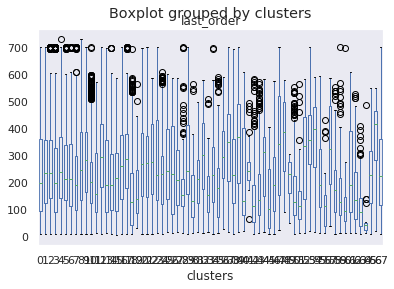

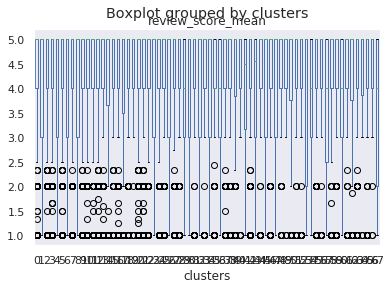

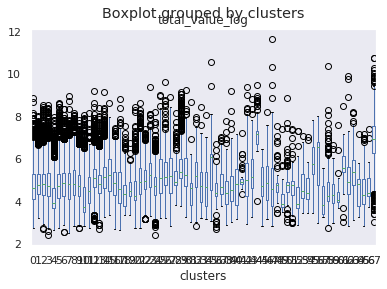

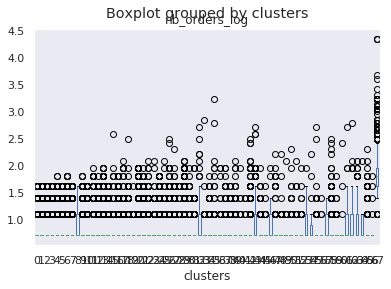

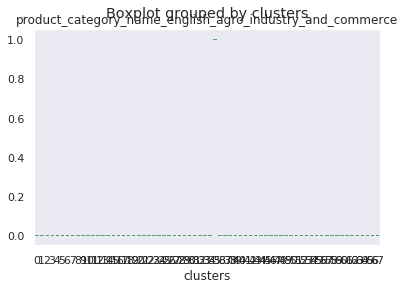

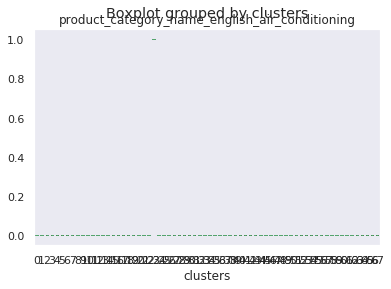

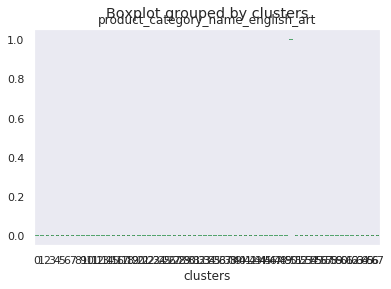

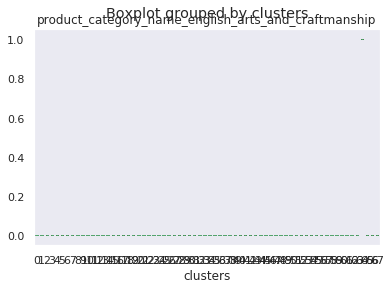

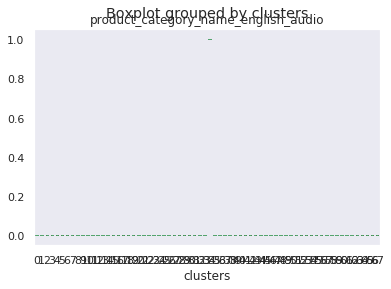

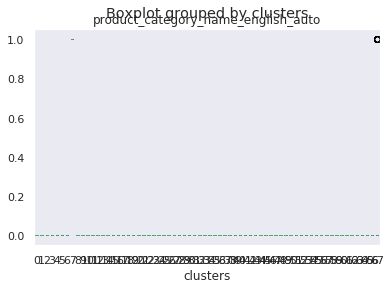

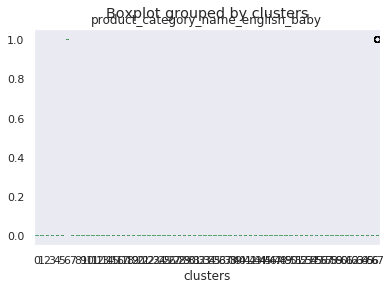

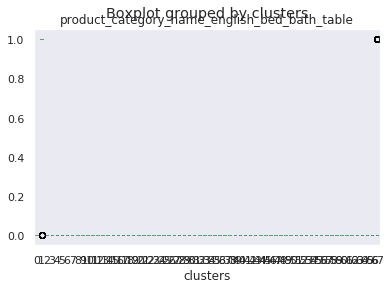

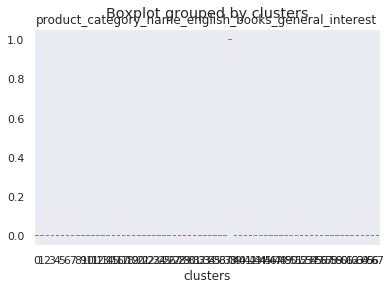

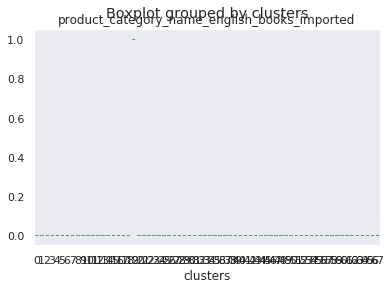

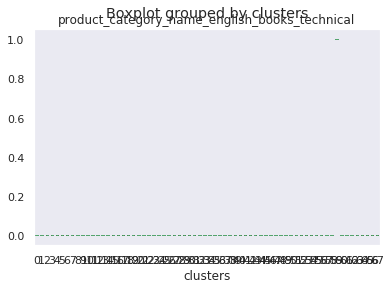

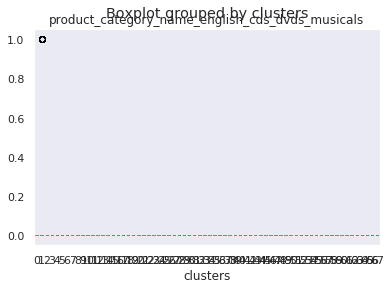

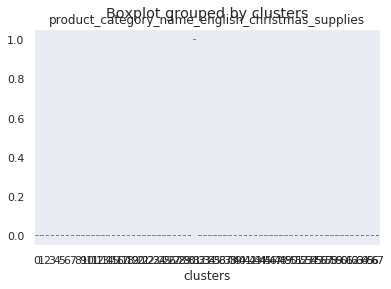

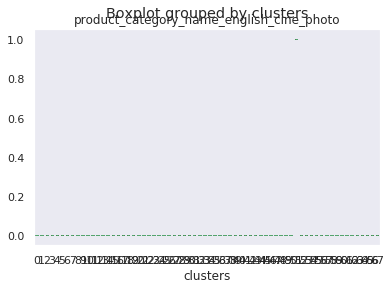

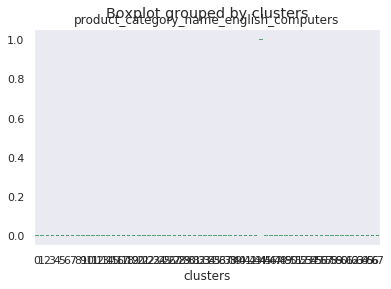

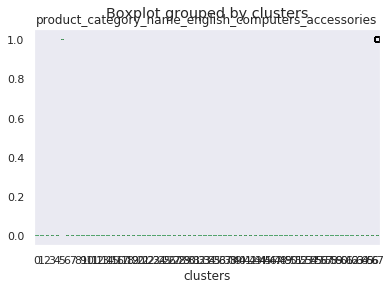

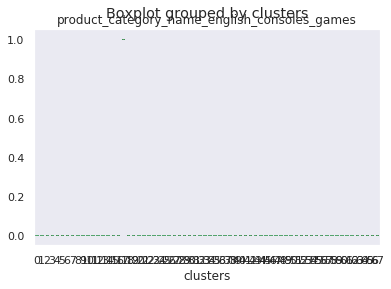

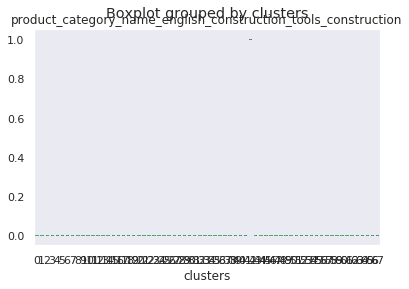

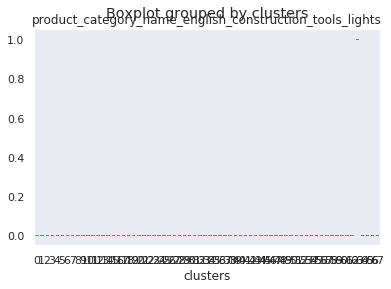

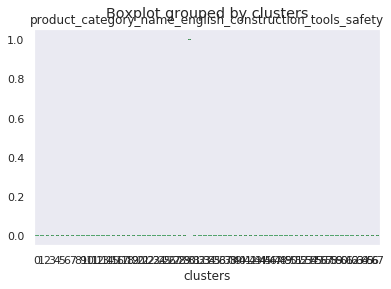

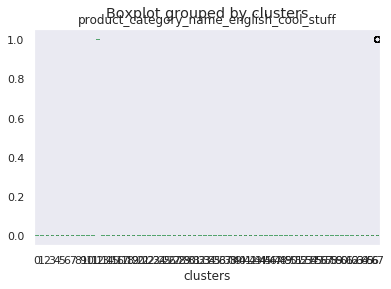

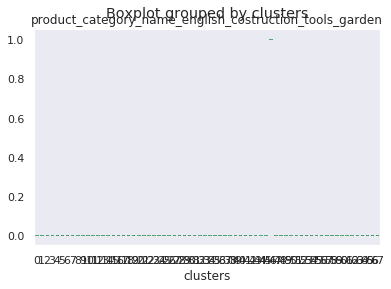

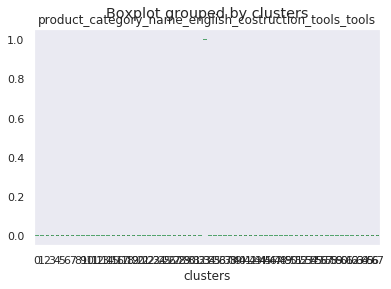

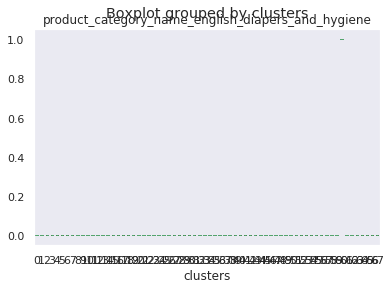

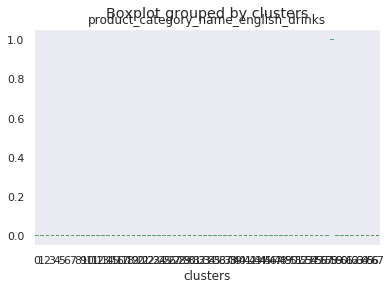

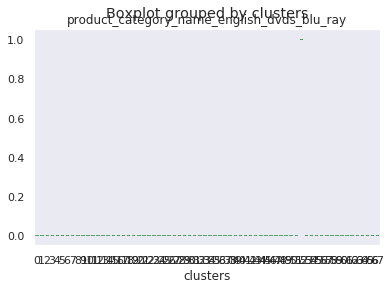

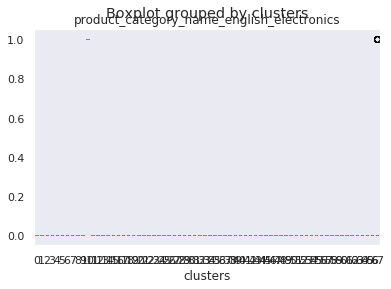

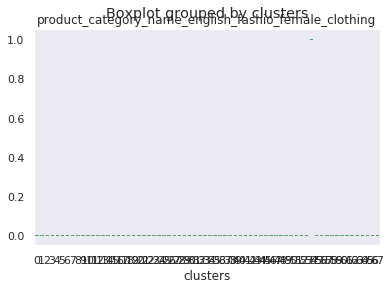

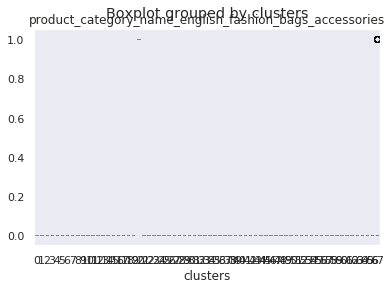

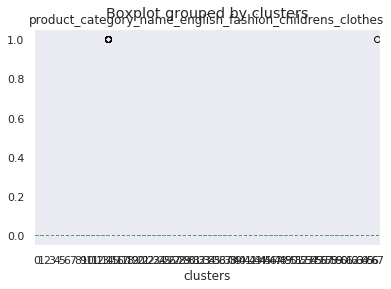

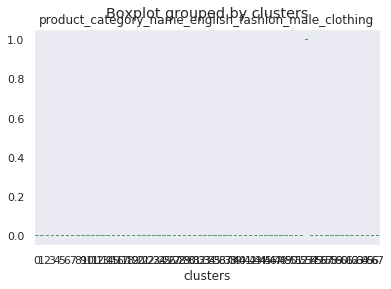

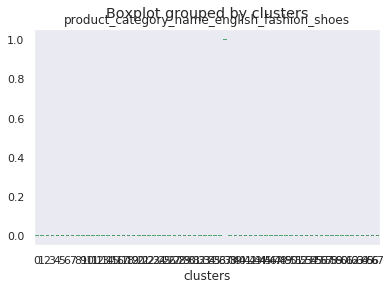

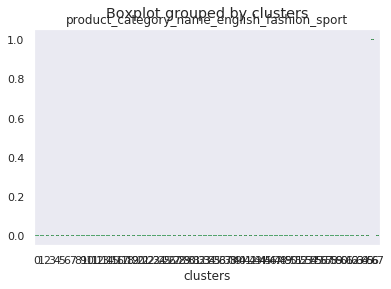

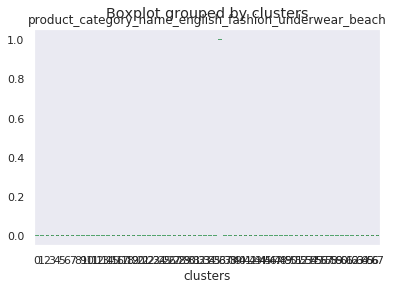

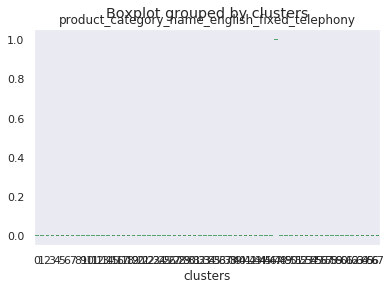

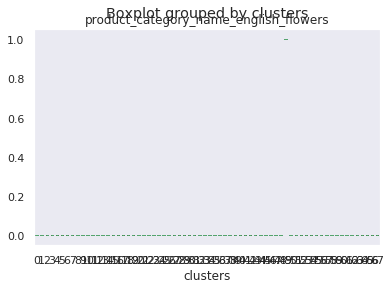

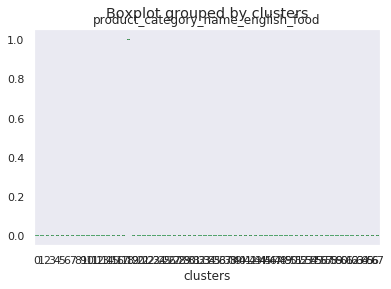

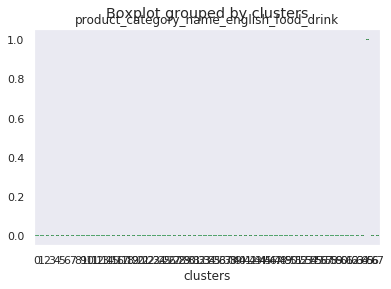

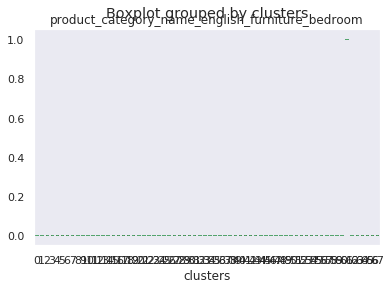

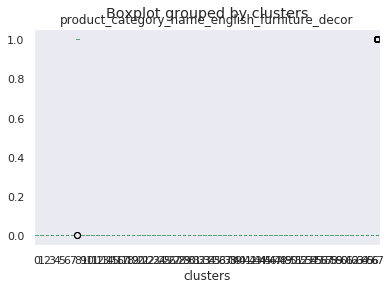

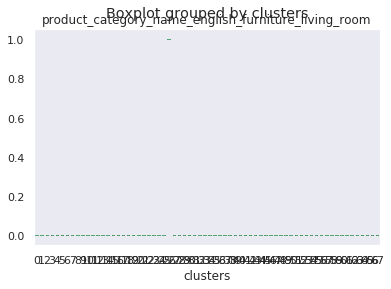

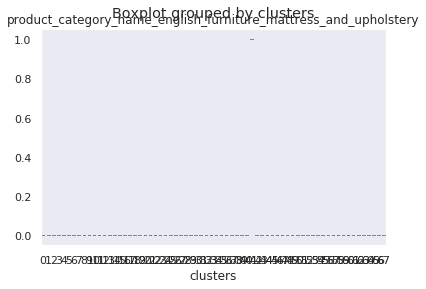

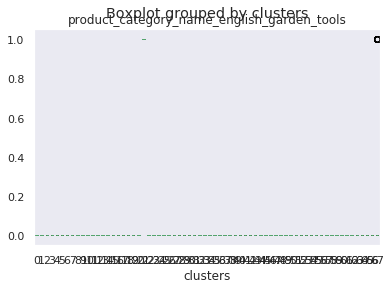

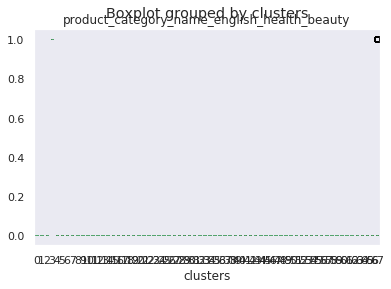

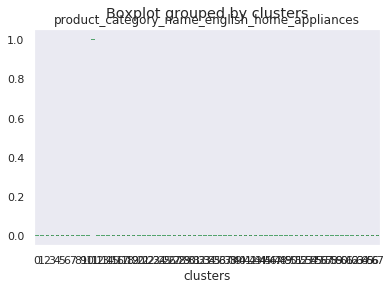

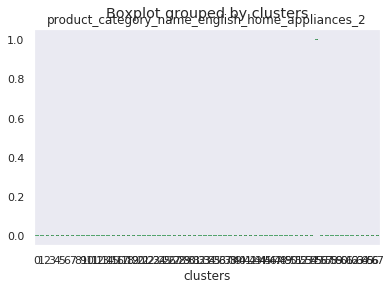

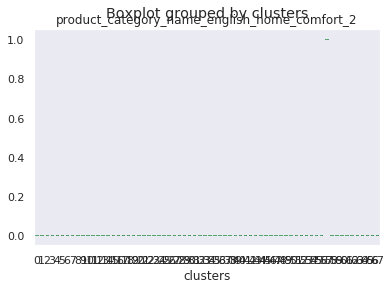

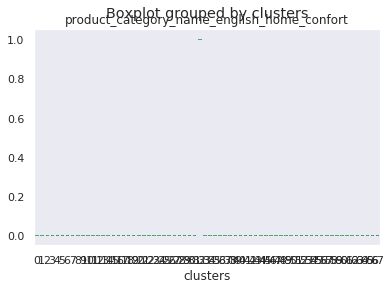

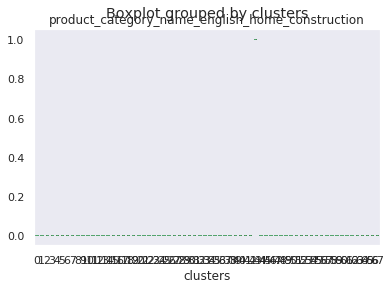

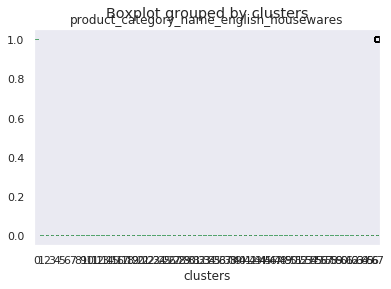

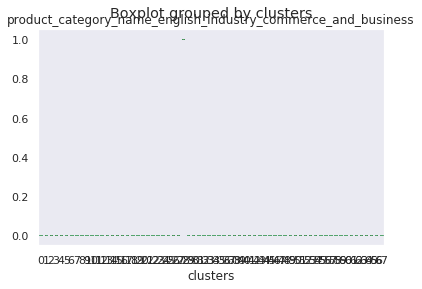

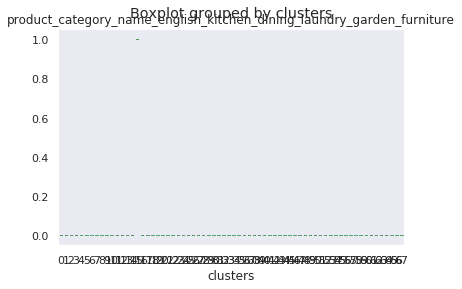

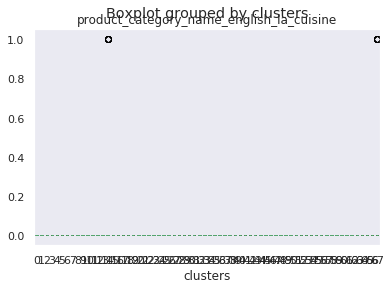

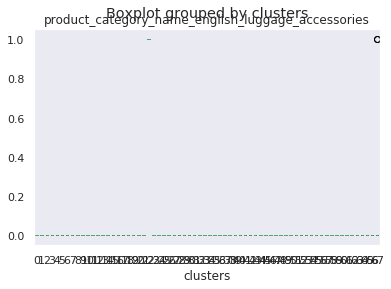

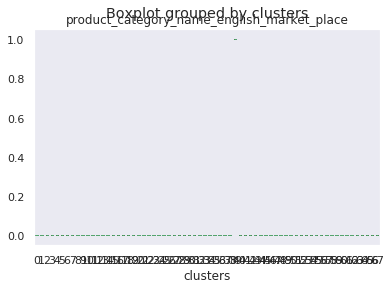

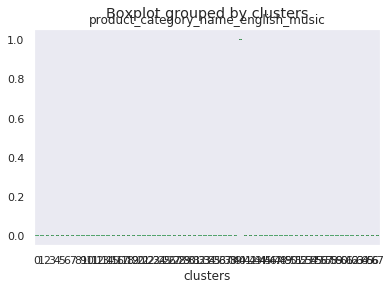

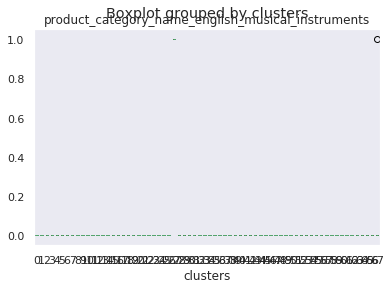

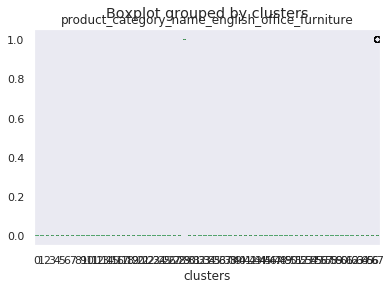

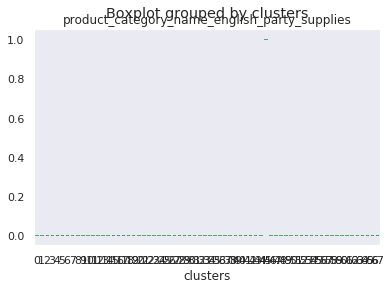

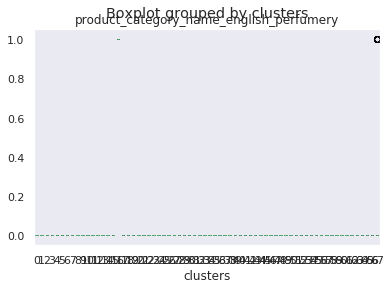

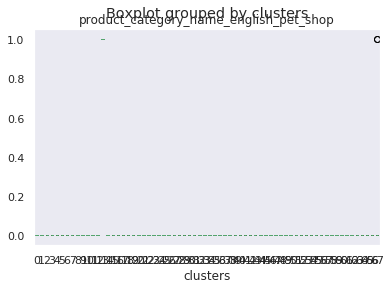

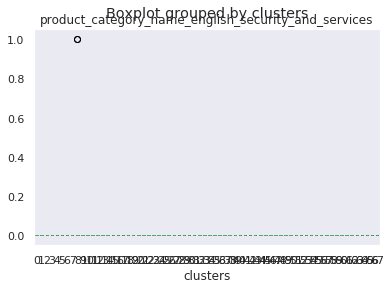

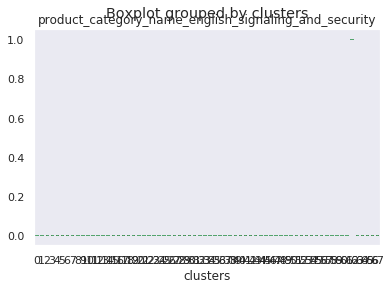

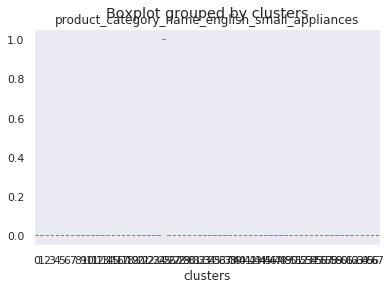

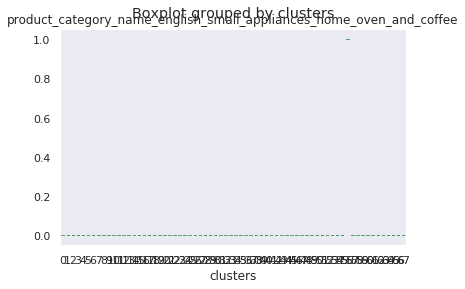

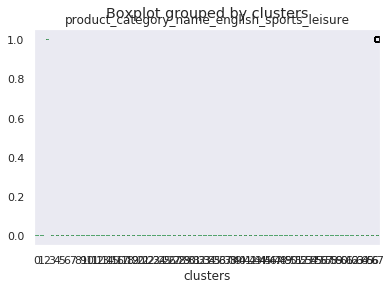

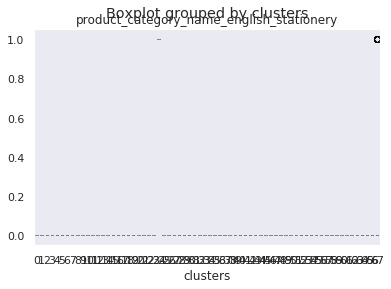

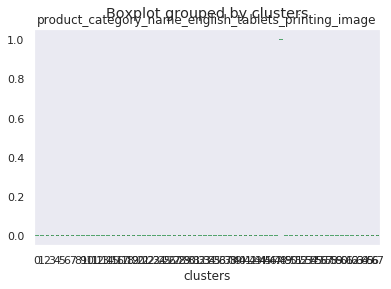

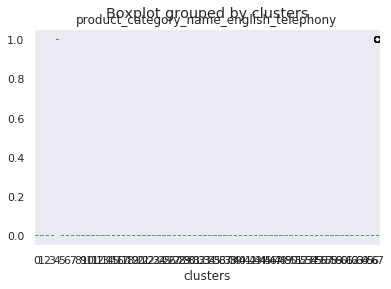

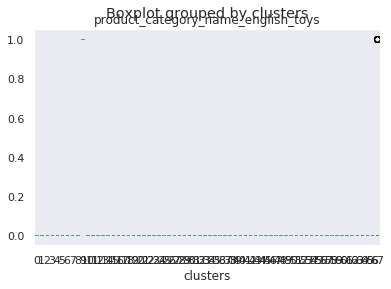

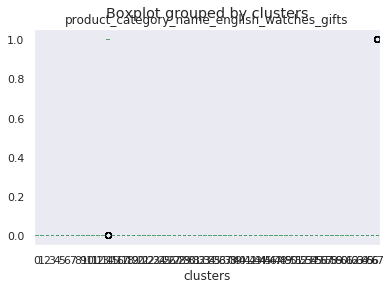

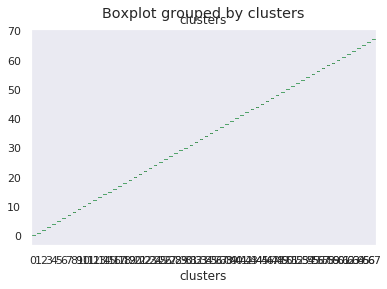

In [0]:
kmeans = KMeans(n_clusters=68, random_state=1).fit(X_projected)
kmeans.fit(X_projected)
y_kmeans = kmeans.predict(X_projected)
centers = kmeans.cluster_centers_
columns = X.columns

print ("Nombre de clusters : ", len(centers))
print ("Nombre de variables : ", len(columns))

X['clusters'] = y_kmeans

col = X.columns

sns.set()
clusterstotal = X.groupby(['clusters'])
countclusterstotal = clusterstotal['clusters'].count()
countclusterstotal = countclusterstotal.sort_values(ascending=False)
labels = countclusterstotal.index
sizes = countclusterstotal.values
'''
# Pairplot
sns.set()
sns.pairplot(X, height=5, hue='clusters')
plt.show()
'''
sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.show()

print (labels, sizes)

for c in col:
    sns.set()
    X.boxplot(by='clusters', column=[c], grid=False)
    plt.plot()


<h2>Sans catégories de produits

Comme nous l'avons vu précédemment, les catégories (ou métacatégories) de produits ne semblent pas permettre le clustering des clients. Nous avons donc créé un fichier de données en retirant ces variables, et appliquons l'algorithme de K-means comme précédemment

For n_clusters = 2 The average silhouette_score is : 0.3776705200628983
For n_clusters = 3 The average silhouette_score is : 0.33389737089706756
For n_clusters = 4 The average silhouette_score is : 0.3037796898357744
For n_clusters = 5 The average silhouette_score is : 0.2941499894566486
For n_clusters = 6 The average silhouette_score is : 0.28087713786902213
For n_clusters = 7 The average silhouette_score is : 0.28656902787231486


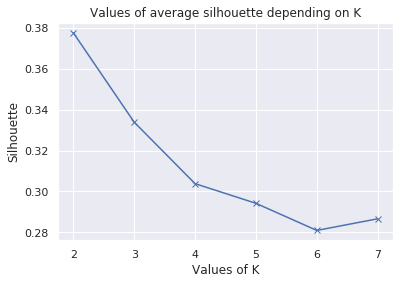

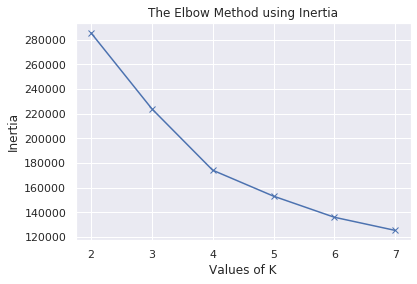

In [0]:
K = range(2, 8)
distortions = []
inertias = []
silhouette = []
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    cluster_labels = kmeanModel.fit_predict(X_var_projected)
    distortions.append(sum(np.min(cdist(X_var_projected,
                                        kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) /
                       X_var_projected.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouette_avg = metrics.silhouette_score(X_var_projected, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", k, "The average silhouette_score is :",
          silhouette_avg)

sns.set()
plt.plot(K, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('Values of average silhouette depending on K')
plt.show()

sns.set()
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


Nous pouvons voir que le meilleur résultat ici serait de faire 4 groupes, ce qui semble bien plus cohérent et logique d'utilisation pour les campagnes de communication. De plus, la répartition du nombre de clients par client est plutôt équitable : il n'y a pas de groupe majoritaire, ni de groupe "vide".

Pour une répartition en 4 clusters, on a donc :

* Cluster 0 : clients les moins satisfaits
* Cluster 1 : commandes les plus anciennes
* Cluster 2 : plusieurs commandes, montant le plus haut
* Cluster 3 : commandes les plus récentes

Nous avons donc bel et bien une répartition bien distincte entre chaque cluster, ce qui nous confirme le choix de ces 4 groupes.


Nombre de clusters :  4
Nombre de variables :  4


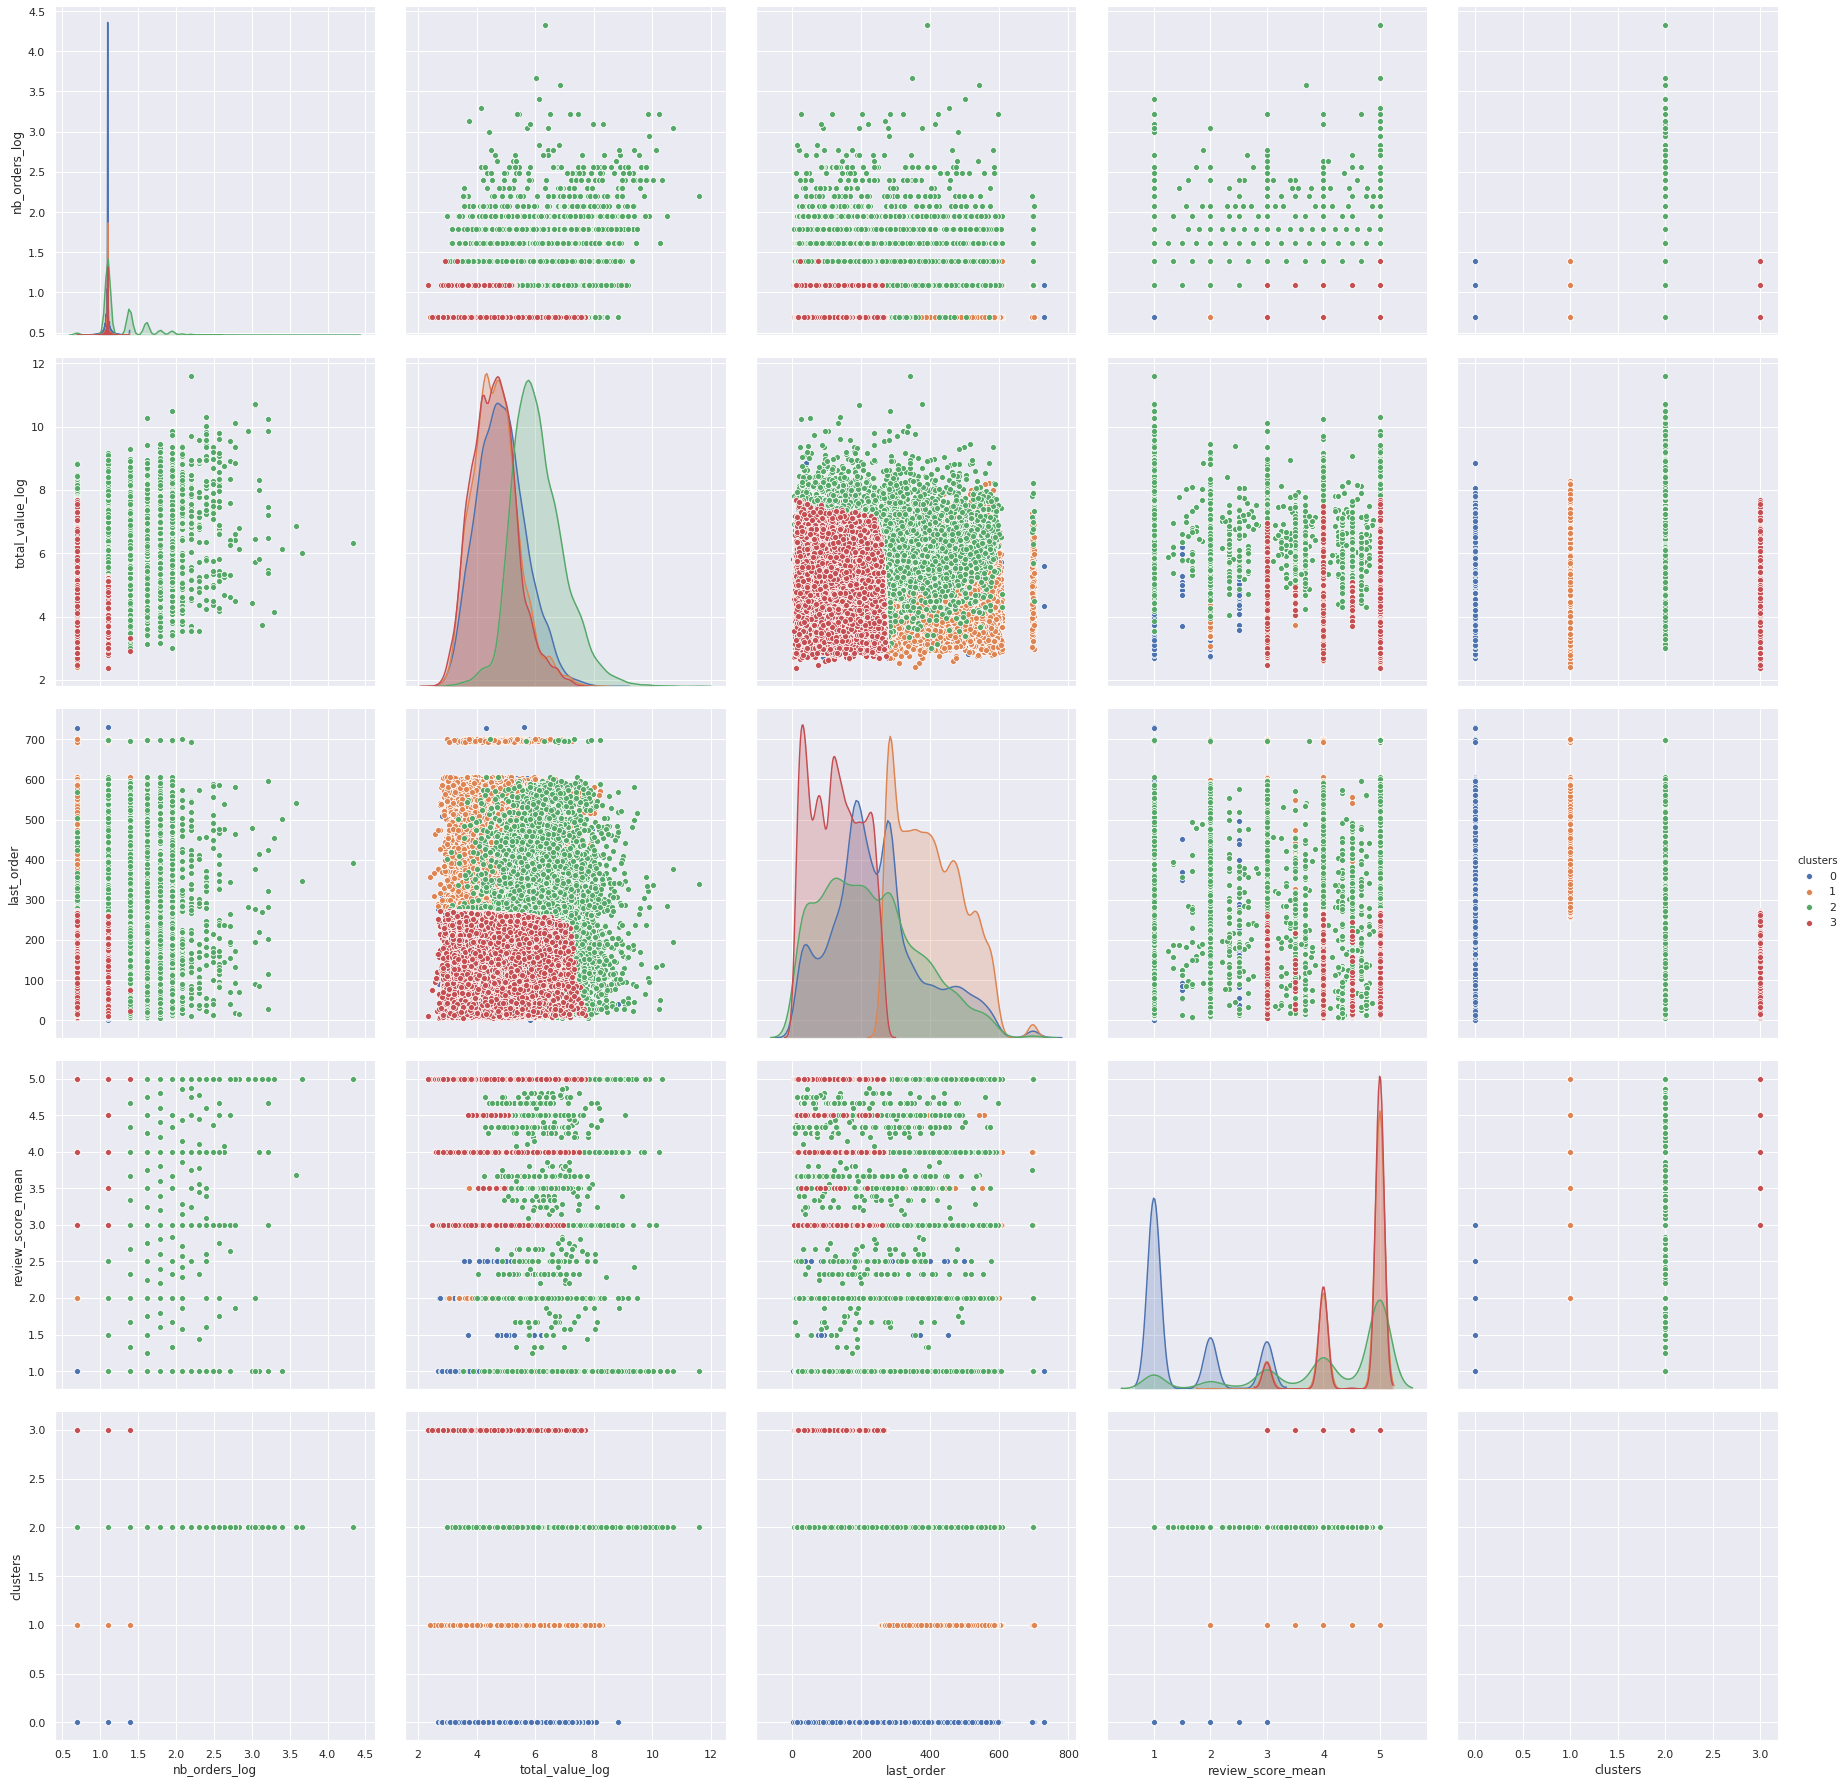

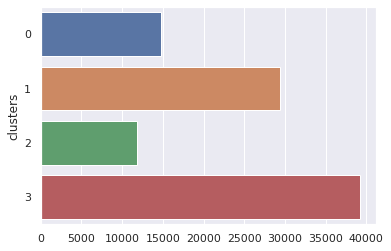

Int64Index([3, 1, 0, 2], dtype='int64', name='clusters') [39162 29337 14758 11818]


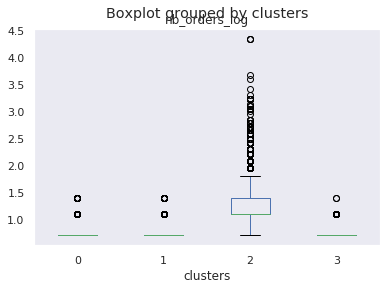

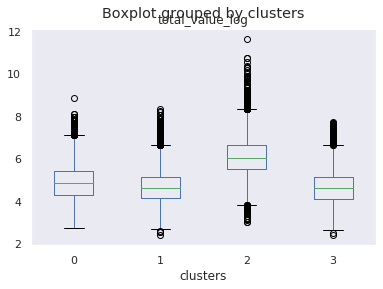

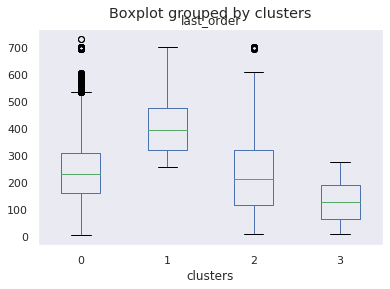

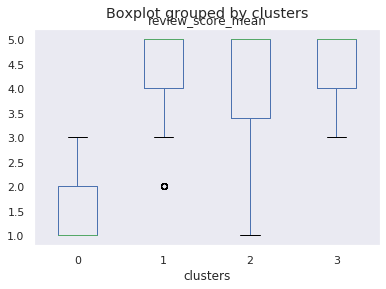

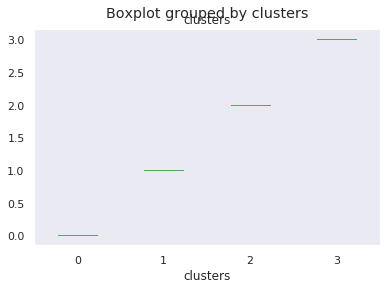

In [0]:
kmeans_var = KMeans(n_clusters=4, random_state=1).fit(X_var_projected)
kmeans_var.fit(X_var_projected)
y_kmeans_var = kmeans_var.predict(X_var_projected)
centers_var = kmeans_var.cluster_centers_
columns_var = X_var.columns

print ("Nombre de clusters : ", len(centers_var))
print ("Nombre de variables : ", len(columns_var))

X_var['clusters'] = y_kmeans_var
col = X_var.columns

sns.set()
clusterstotal = X_var.groupby(['clusters'])
countclusterstotal = clusterstotal['clusters'].count()
countclusterstotal = countclusterstotal.sort_values(ascending=False)
labels = countclusterstotal.index
sizes = countclusterstotal.values

# Pairplot
sns.set()
sns.pairplot(X_var, height=5, hue='clusters')
plt.show()

sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.show()

print (labels, sizes)

for c in col:
    sns.set()
    X_var.boxplot(by='clusters', column=[c], grid=False)
    plt.plot()


# DBScan

Maintenant que nous avons défini le réel fichier d'intérêt pour le clustering, nous allons tester d'autres algorithmes de clustering. Ici, nous testons le DBScan, qui est un algorithme se basant sur des itérations de la densité des points entourant chaque point (par calcul d'epsilon-voisinage), formant ainsi les groupes. 

Nous obtenons ainsi 7 groupes, mais la répartition dans les clusters n'est pas bonne : 80000 clients sont dans un unique cluster. Ce ne sera donc pas la solution retenue ici.

In [0]:
# eps=1 : maximum value before crashing the Colaboratory session

db_var = DBSCAN(eps=1).fit(X_var_projected)
core_samples_mask = np.zeros_like(db_var.labels_, dtype=bool)
core_samples_mask[db_var.core_sample_indices_] = True
clusters_var = db_var.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters__var = len(set(clusters_var)) - (1 if -1 in clusters_var else 0)
n_noise__var = list(clusters_var).count(-1)

print ("Nombre de clusters obtenus :", n_clusters__var)
print ("Nombre de clients non classés :", n_noise__var)


Nombre de clusters obtenus : 7
Nombre de clients non classés : 67


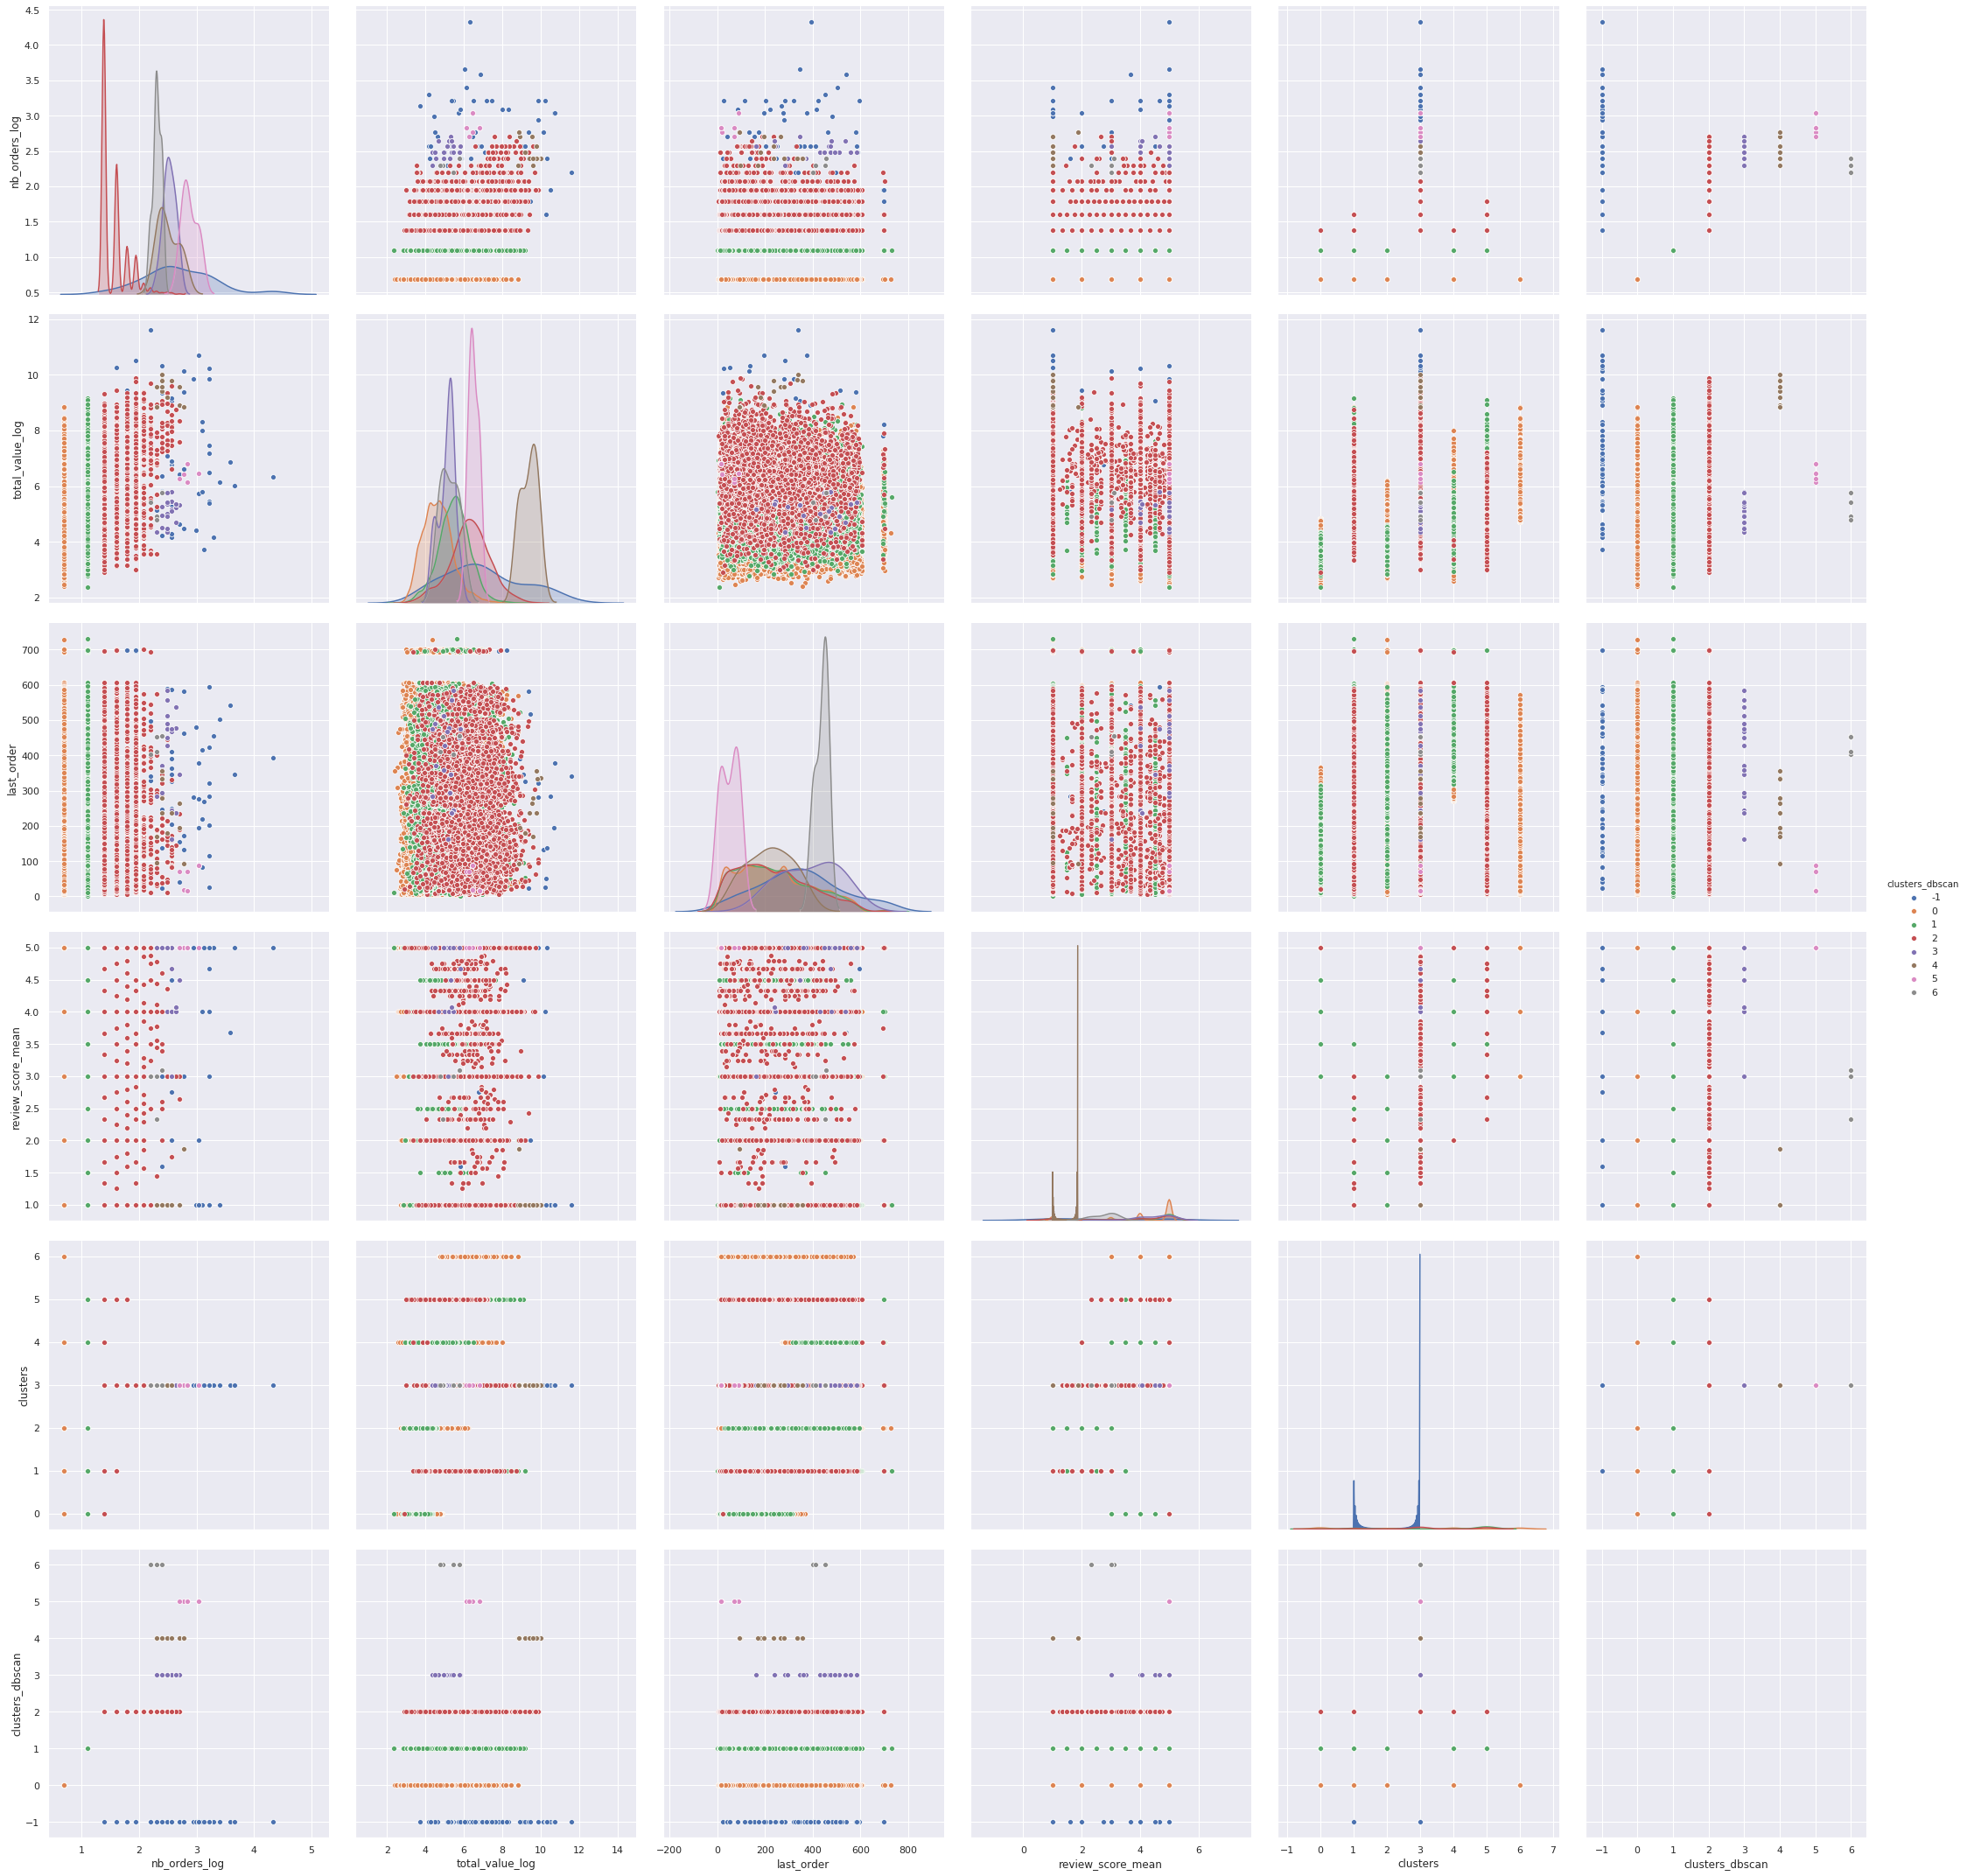

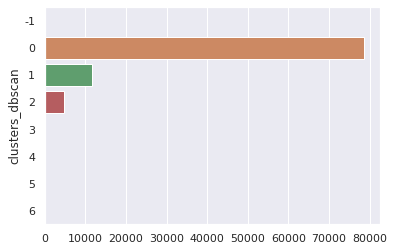

Int64Index([0, 1, 2, -1, 3, 4, 5, 6], dtype='int64', name='clusters_dbscan') [78492 11748  4718    67    22    13     9     6]


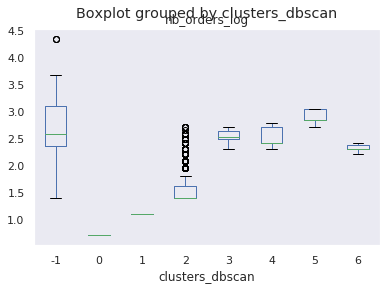

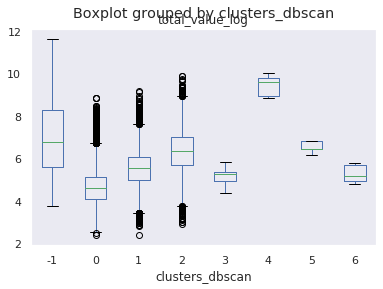

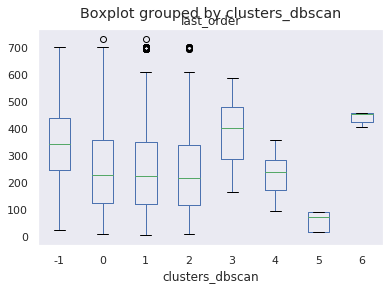

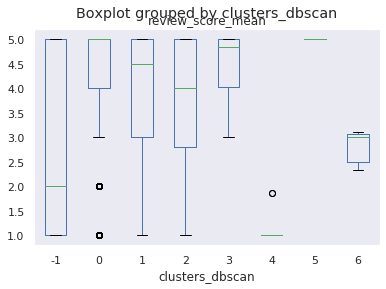

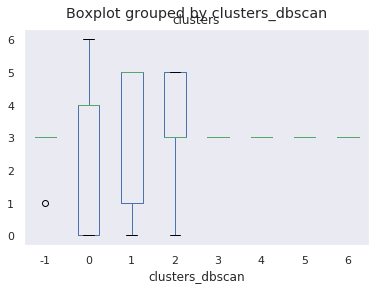

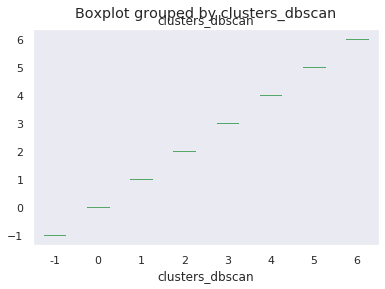

In [0]:
X_var['clusters_dbscan'] = clusters_var

col = X_var.columns

sns.set()
clusterstotal = X_var.groupby(['clusters_dbscan'])
countclusterstotal = clusterstotal['clusters_dbscan'].count()
countclusterstotal = countclusterstotal.sort_values(ascending=False)
labels = countclusterstotal.index
sizes = countclusterstotal.values

# Pairplot
sns.set()
sns.pairplot(X_var, height=5, hue='clusters_dbscan')
plt.show()

sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.show()

print (labels, sizes)

for c in col:
    sns.set()
    X_var.boxplot(by='clusters_dbscan', column=[c], grid=False)
    plt.plot()


# Gaussian Mixture

Enfin, le troisième et dernier algorithme étudié dans ce projet est le Gaussian Mixture. Ici, on considère tous les points comme provenant d'une combinaison de distributions gaussiennes dont nous ne connaissons pas les paramètres. Cela se rapproche donc d'un K-means avec l'ajout d'information sur la covariance.

In [0]:
n_composants = range(1, 8)
models = []
for n in n_composants:
    models.append(mixture.GaussianMixture(n, covariance_type='full',
                                          random_state=1).fit(X_var_projected))
    print (n, " _ ", len(models))


1  _  1
2  _  2
3  _  3
4  _  4
5  _  5
6  _  6
7  _  7


In [0]:
n_composants = range(8, 15)
for n in n_composants:
    models.append(mixture.GaussianMixture(n, covariance_type='full',
                                          random_state=1).fit(X_var_projected))
    print (n, " _ ", len(models))


8  _  8
9  _  9
10  _  10
11  _  11
12  _  12
13  _  13
14  _  14


Pour connaître le nombre de clusters, après calcul de toutes les possibilités, nous analysons les valeurs d'AIC et sélectionnons la plus haute valeur comme étant celle donnant le même résultat de clustering, qui est donc ici à 8 groupes. Cependant, la répartition dans les clusters semble être moins optimale que dans les 4 du K-means

Text(0.5, 0, 'n_composants')

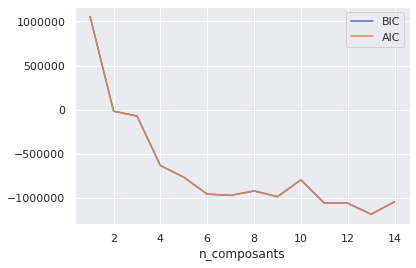

In [0]:
n_composants = range(1, 15)

bic_values = [m.bic(X_var_projected) for m in models]
aic_values = [m.aic(X_var_projected) for m in models]


plt.plot(n_composants, bic_values, label='BIC')
plt.plot(n_composants, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_composants')


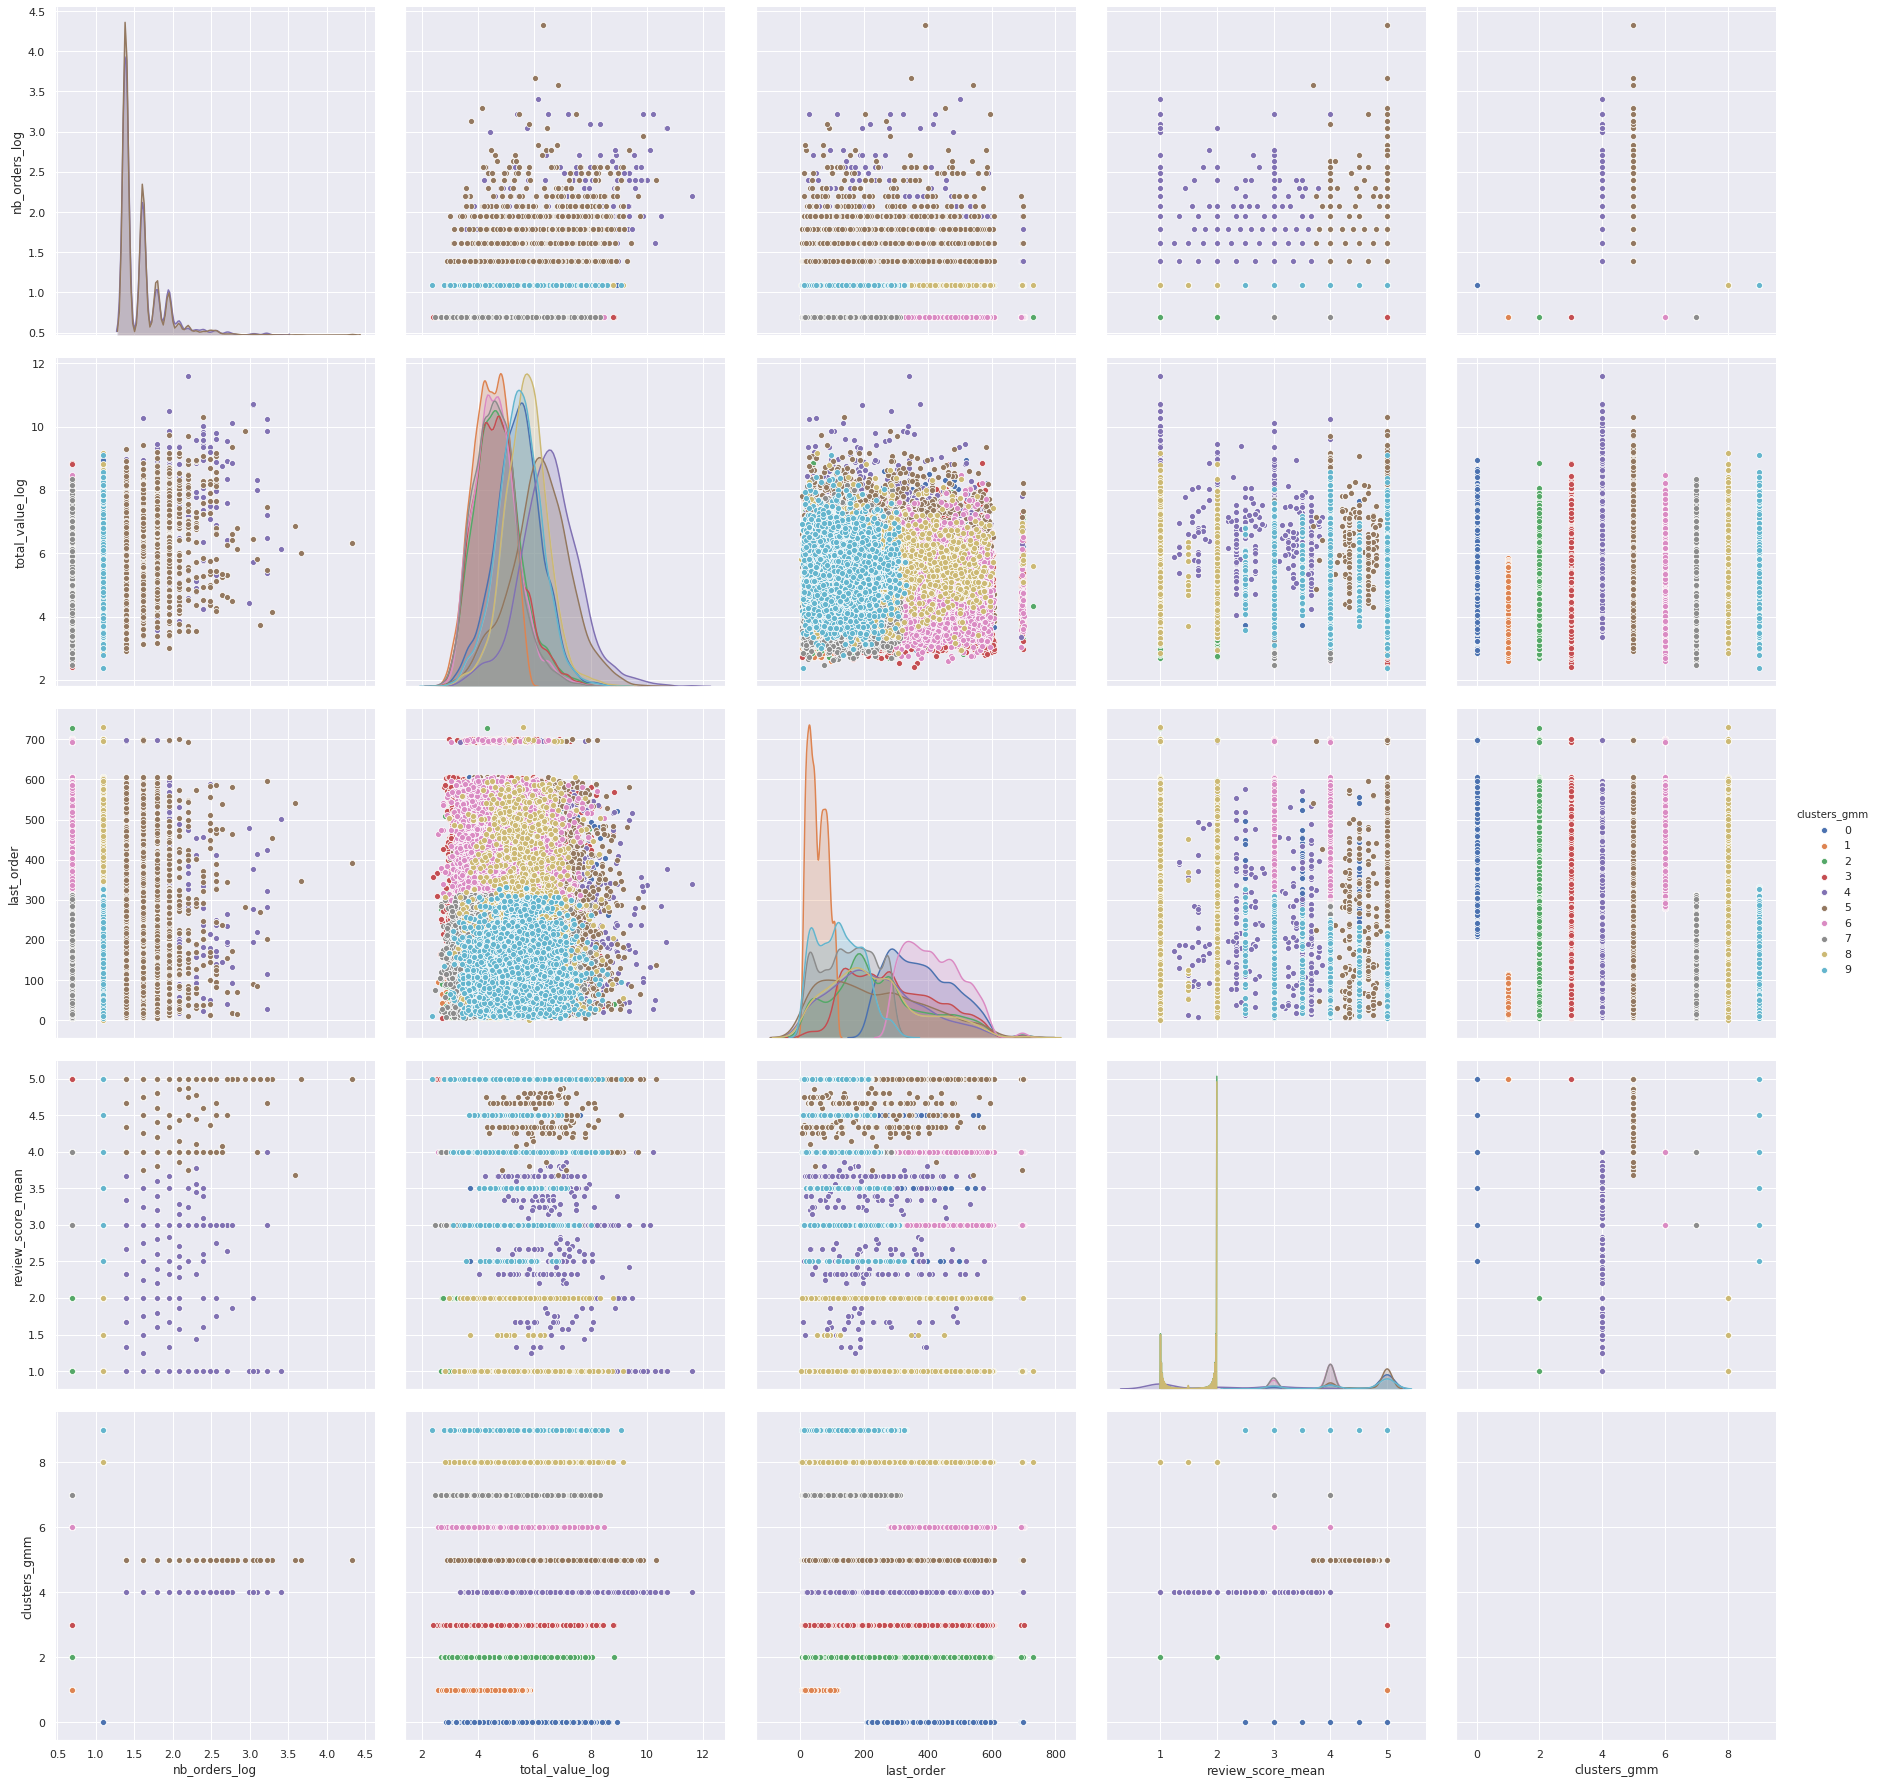

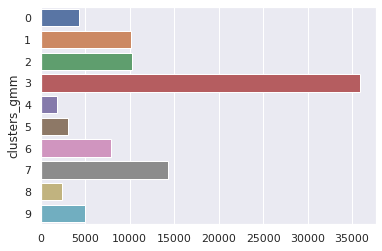

Int64Index([3, 7, 2, 1, 6, 9, 0, 5, 8, 4], dtype='int64', name='clusters_gmm') [35844 14341 10310 10145  7852  5025  4309  3024  2414  1811]


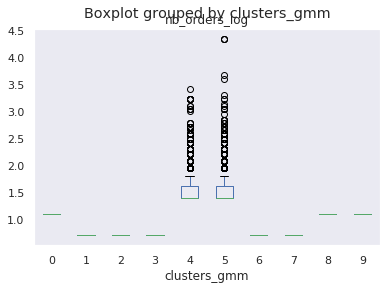

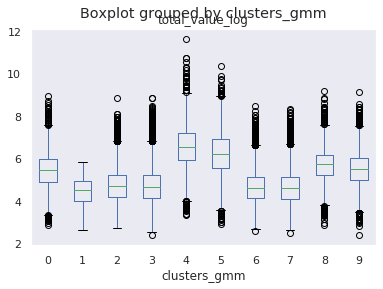

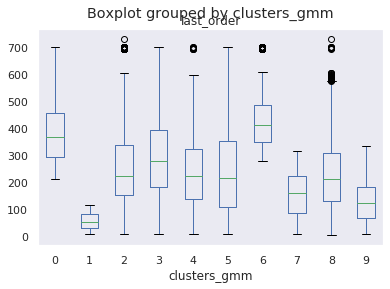

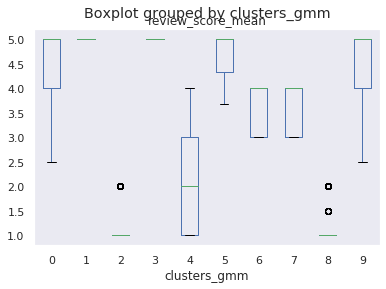

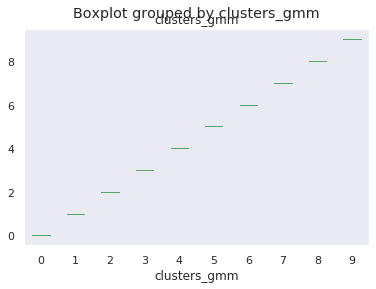

In [0]:
gmm = mixture.GaussianMixture(10, covariance_type='full',
                              random_state=1).fit(X_var_projected)
labels = gmm.predict(X_var_projected)

X_var['clusters_gmm'] = labels

col = X_var.columns

sns.set()
clusterstotal = X_var.groupby(['clusters_gmm'])
countclusterstotal = clusterstotal['clusters_gmm'].count()
countclusterstotal = countclusterstotal.sort_values(ascending=False)
labels = countclusterstotal.index
sizes = countclusterstotal.values

# Pairplot
sns.set()
sns.pairplot(X_var, height=5, hue='clusters_gmm')
plt.show()

sns.set()
fig, ax = plt.subplots()
sns.barplot(x=sizes, y=labels, orient="h")
plt.show()

print (labels, sizes)

for c in col:
    sns.set()
    X_var.boxplot(by='clusters_gmm', column=[c], grid=False)
    plt.plot()


# Calcul du protocole de maintenance

Maintenant que le nombre de groupes a été défini ainsi que leur composition, il reste une tâche à définir dans ce projet : proposer un contrat de maintenance. Cela signifie qu'il fait donner une durée pendant laquelle notre modèle reste applicable, et où après laquelle le modèle doit donc être recalculé pour donner des clusterings valables. 

In [0]:
# Data import into the notebook, from Google Drive
link1 = "https://drive.google.com/open?id=1Sv40SVNbgxRX6TwjtfffUC88sdaXw6Du"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_customers_dataset.csv')
datacustomers = pd.read_csv('olist_customers_dataset.csv', sep=',')
print ("Customers Dataset importées")

link1 = "https://drive.google.com/open?id=1BPc3th-yYVkfEQvrAG0dnnyLHkRJuaJs"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_geolocation_dataset.csv')
datageolocalisation = pd.read_csv('olist_geolocation_dataset.csv', sep=',')
print ("Geolocalisation Dataset importées")

link1 = "https://drive.google.com/open?id=1TDePhYE2CqsXnOcRtw53ox-Qv2d3WWmi"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_order_items_dataset.csv')
dataorderitems = pd.read_csv('olist_order_items_dataset.csv', sep=',')
print ("Order Items Dataset importées")

link1 = "https://drive.google.com/open?id=13Qfhd8Svj9AswgHfCfjLBxhNVkOtpFj_"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_order_payments_dataset.csv')
dataorderpayments = pd.read_csv('olist_order_payments_dataset.csv', sep=',')
print ("Order Payments Dataset importées")

link1 = "https://drive.google.com/open?id=1VmVig7vbB56qMAWZl2JOt7wn3gL7Jps9"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_order_reviews_dataset.csv')
dataorderreviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',')
print ("Order Reviews Dataset importées")

link1 = "https://drive.google.com/open?id=1bHGS3l1l4EQel_5VfJEOKkeJYNohRHHA"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_orders_dataset.csv')
dataorders = pd.read_csv('olist_orders_dataset.csv', sep=',')
print ("Order Dataset importées")

link1 = "https://drive.google.com/open?id=1USTl_YI46Ftwf-SYCgqkDZ9N_5Tat1T3"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_products_dataset.csv')
dataproducts = pd.read_csv('olist_products_dataset.csv', sep=',')
print ("Products Dataset importées")

link1 = "https://drive.google.com/open?id=1w7uWmu0la5FRJOXfS4dVPBMZzc4LO6SK"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('olist_sellers_dataset.csv')
datasellers = pd.read_csv('olist_sellers_dataset.csv', sep=',')
print ("Sellers Dataset importées")

link1 = "https://drive.google.com/open?id=1r1CnhSv-NY5yZIOMMpxBv1ypjZDjtdc_"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('product_category_name_translation.csv')
datacategories = pd.read_csv('product_category_name_translation.csv', sep=',')
print ("Categories Dataset importées")


Customers Dataset importées
Geolocalisation Dataset importées
Order Items Dataset importées
Order Payments Dataset importées
Order Reviews Dataset importées
Order Dataset importées
Products Dataset importées
Sellers Dataset importées
Categories Dataset importées


Pour cela, nous recréons le fichier nettoyé de la base de données, et nous sélectionnons ensuite les commandes entrant dans un intervalle de dates donné.

Considérons un ensemble de commandes 2 réalisées jusqu'au 19 août 2018 (noté ici data1) et un ensemble de commandes réalisées jusqu'au 3 septembre 2018 (noté ici data2). Nous appliquons sur data1 le k-means, et nous utilisons ce modèle sur data2 pour prédire les clusters de ce data. Nous appliquons ensuite sur data2 le k-means pour aussi en prédire les clusters.

Une fois les deux prédictions de clusters obtenues, nous les comparons : si le nombre de différences est trop important (>10%), le modèle doit de nouveau être appliqué. Ceci est appliqué sur plusieurs données, pour augmenter la différence de dates de 15 jours.

Il y a plus de 10% de différences à partir de 4 mois. La différence s'explique d'ailleurs par des différences de répartition certes sur le délai, ce qui est normal au vu des données sélectionnées (intervalle de temps), mais aussi par le montant des commandes (qui diminue vu que le nombre total de commandes change avec le temps). Le cluster se résumant par les avis négatifs (cluster 0) ne varie cependant pas entre les K-means.

Les différences notables sont donc essentiellement sur le cluster 1, par les changements de délai depuis la dernière commande et des extrêmes de review supplémentaires.

Au vu du taux de différences de 25% environ à 4 mois, nous choisissons une différence un peu plus basse, à savoir 3,5 mois.

In [0]:
# Assembly of order data and order payment data
data_payment = pd.merge(dataorders, dataorderpayments, on=['order_id'])
data_payment.drop(['order_status', 'order_approved_at',
                   'order_delivered_carrier_date',
                   'order_delivered_customer_date',
                   'order_estimated_delivery_date', 'payment_sequential',
                   'payment_type', 'payment_installments'], axis=1,
                  inplace=True)

# Assembly with unique customer ID
custom = pd.DataFrame(datacustomers[['customer_id', 'customer_unique_id']])
data_payment_custom = pd.merge(data_payment, custom)
data_payment_custom.drop(['customer_id'], axis=1, inplace=True)

# Assembly with review data
data_review = pd.merge(data_payment_custom, dataorderreviews, on=["order_id"])
data_review.drop(['review_id', 'review_comment_title',
                  'review_comment_message', 'review_creation_date',
                  'review_answer_timestamp'], axis=1, inplace=True)

# Assembly with orders and products
data_products = pd.merge(dataproducts, dataorderitems)
data_products.drop(['product_category_name', 'product_name_lenght',
                    'product_description_lenght', 'product_photos_qty',
                    'product_weight_g', 'product_length_cm',
                    'product_height_cm', 'product_width_cm', 'order_item_id',
                    'seller_id', 'shipping_limit_date', 'price',
                    'freight_value'], axis=1, inplace=True)
integral_data = pd.merge(data_products, data_review)

integral_data['order_purchase_timestamp_date'] = pd.to_datetime(integral_data[
    'order_purchase_timestamp'].apply(lambda x: x[0:10]))
integral_data.drop(['order_purchase_timestamp'], axis=1, inplace=True)


In [0]:
# Creation of data1 and data2
def filtre_data(integral_data, date1):
    masque = integral_data['order_purchase_timestamp_date'] <= date1
    data = integral_data[masque]
    return (data)


# Calcul of all variables from data
def calcul_var(data, date_max):
    data_final = data.groupby('customer_unique_id').agg(
      total_value=('payment_value', lambda x: x.sum()),
      nb_orders=('order_id', lambda x: int(x.count())),
      last_order=('order_purchase_timestamp_date',
                  lambda x: ((date_max-x)/np.timedelta64(1, 'D') + 1).min()),
      review_score_mean=('review_score', lambda x: x.mean()),
    )
    print ("Data_final : ", len(data_final))
    print ("Fin agg data")

    print (data_final.skew(axis=0, skipna=True))
    data_final["total_value_log"] = (np.log(data_final["total_value"]+1))
    data_final["nb_orders_log"] = (np.log(data_final["nb_orders"]+1))
    data_final.drop(["total_value"], axis=1, inplace=True)
    print (data_final.columns)
    print (data_final.iloc[0])
    return (data_final)


# Choice of the sample and initialization of variables
def preparation_X(data):
    X = data
    print ("Fin préparation")
    return (X)


# Correspondence between the two lists of clusters
def change_cluster(x, corresp):
    y = corresp[x]
    return (y)


# Calcul of differences between the two lists of clusters
def dif_clusters(X_2):
    comp_clusters = {}
    clust1 = {}
    clust2 = {}
    diff_clust = {0: 0, 1: 0, 2: 0, 3: 0}
    for x in range(len(X_2)):
        clust = X_2.iloc[x]
        if (clust['newclustersmodancien'] in clust1):
            clust1[clust['newclustersmodancien']] += 1
        else:
            clust1[clust['newclustersmodancien']] = 1
        if (clust["clustersmodrecent"] in clust2):
            clust2[clust["clustersmodrecent"]] += 1
        else:
            clust2[clust["clustersmodrecent"]] = 1
        if clust['newclustersmodancien'] != clust["clustersmodrecent"]:
            comp = str(clust['newclustersmodancien'])+"-"+str(clust[
                "clustersmodrecent"])
            diff_clust[clust['newclustersmodancien']] += 1
            if (comp in comp_clusters):
                comp_clusters[comp] += 1
            else:
                comp_clusters[comp] = 1
    X_2['differences'] = (X_2["newclustersmodancien"] != X_2[
        "clustersmodrecent"])
    differences = (X_2['differences'].sum()/X_2.shape[0])*100
    print ("Nombre de différences : ", differences)
    print ("Différences entre clusters (clustancien - clustrecent) :",
           comp_clusters)
    print ("Clusters 1 : ", clust1)
    print ("Clusters 2 : ", clust2)
    graph_clusters(X_2)
    return (differences, diff_clust, clust1)


def complete_cluster(X_2):
    X_2mod = X_2[['nb_orders_log', 'total_value_log', 'last_order',
                  'review_score_mean']]
    std_scale = preprocessing.StandardScaler()
    std_scale.fit(X_2mod)
    X2_scaled = std_scale.transform(X_2mod)
    pca_final = PCA(n_components=0.9)
    pca_final.fit(X2_scaled)
    X2_projected = pca_final.transform(X2_scaled)
    kmeans_2 = KMeans(n_clusters=4, random_state=1)
    kmeans_2.fit(X2_projected)
    # Prediction of most recent clusters from the recent model
    y_kmeans_2_2 = kmeans_2.predict(X2_projected)
    X_2['clustersmodrecent'] = y_kmeans_2_2
    return (X_2)


# Calcul of the two k-means and the confusion matrix
def differences(X_1, X_2):
    X_1 = X_1[['nb_orders_log', 'total_value_log', 'last_order',
               'review_score_mean']]
    std_scale1 = preprocessing.StandardScaler()
    std_scale1.fit(X_1)
    X1_scaled = std_scale1.transform(X_1)
    pca_final1 = PCA(n_components=0.9)
    pca_final1.fit(X1_scaled)
    X1_projected = pca_final1.transform(X1_scaled)
    # Calcul of the k-means of the older data
    kmeans_1 = KMeans(n_clusters=4, random_state=1)
    kmeans_1.fit(X1_projected)
    # Prediction of most recent clusters from older model
    X_2mod = X_2[['nb_orders_log', 'total_value_log', 'last_order',
                  'review_score_mean']]
    X2_1_scaled = std_scale1.transform(X_2mod)
    X2_1_projected = pca_final1.transform(X2_1_scaled)
    y_kmeans_1_2 = kmeans_1.predict(X2_1_projected)
    X_2['clustersmodancien'] = y_kmeans_1_2
    # Calcul of the confusion matrix et correspondance of cluster numbers
    confusion_matrice = confusion_matrix(X_2["clustersmodancien"],
                                         X_2["clustersmodrecent"])
    corresp = np.argmax(confusion_matrice, axis=1)
    print ("Correspondance des clusters : ", corresp)
    X_2["newclustersmodancien"] = X_2[
        "clustersmodancien"].apply(lambda x: change_cluster(x, corresp))
    print ("Composition du fichier complet avec clusters")
    print_test(X_2, test)
    # Calcul of difference pourcentage between the two types of clustering
    difference, diff_clust, comp_cluster1 = dif_clusters(X_2)
    return (difference, diff_clust, comp_cluster1)


def graph_clusters(X):
    clusters1total = X.groupby(['newclustersmodancien'])
    countclusters1total = clusters1total['newclustersmodancien'].count()
    countclusters1total = countclusters1total.sort_values(ascending=False)
    labels1 = countclusters1total.index
    sizes1 = countclusters1total.values

    clusters2total = X.groupby(['clustersmodrecent'])
    countclusters2total = clusters2total['clustersmodrecent'].count()
    countclusters2total = countclusters2total.sort_values(ascending=False)
    labels2 = countclusters2total.index
    sizes2 = countclusters2total.values

    sns.set()
    fig, ax = plt.subplots()
    sns.barplot(x=sizes1, y=labels1, orient="h")
    plt.show()

    sns.set()
    fig, ax = plt.subplots()
    sns.barplot(x=sizes2, y=labels2, orient="h")
    plt.show()

    col = ['nb_orders_log', 'total_value_log', 'last_order',
           'review_score_mean']

    for c in col:
        sns.set()
        X.boxplot(by="newclustersmodancien", column=[c], grid=False)
        plt.show()
        sns.set()
        X.boxplot(by='clustersmodrecent', column=[c], grid=False)
        plt.show()


def print_test(X, test):
    for t in test:
        print (X.loc[t])


Date la plus récente : 2018-09-03 00:00:00
Data_final :  95419
Fin agg data
total_value          68.172401
nb_orders            15.550880
last_order            0.448580
review_score_mean    -1.363969
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders              1.000000
last_order           117.000000
review_score_mean      5.000000
total_value_log        4.962145
nb_orders_log          0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
Masque fait
['00053a61a98854899e70ed204dd4bafe', '0000366f3b9a7992bf8c76cfdf3221e2']
Composition du fichier complet
last_order           188.000000
review_score_mean      1.000000
total_value_log        6.732640
nb_orders_log          1.098612
Name: 00053a61a98854899e70ed204dd4bafe, dtype: float64
last_order           117.000000
review_score_mean      5.000000
total_value_log        4.962145
nb_orders_log          0.693147
Name: 0000366f3b9a7992

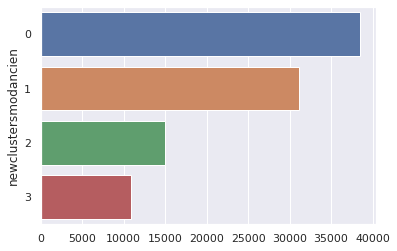

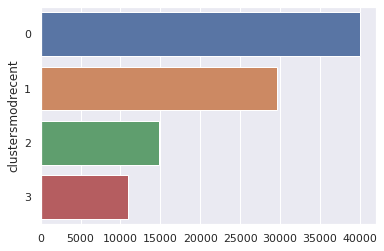

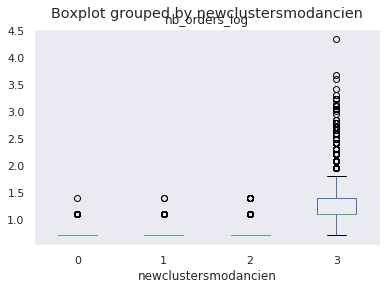

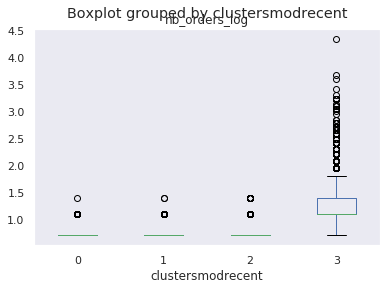

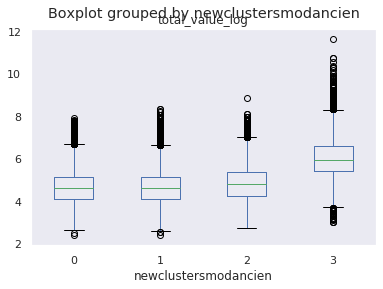

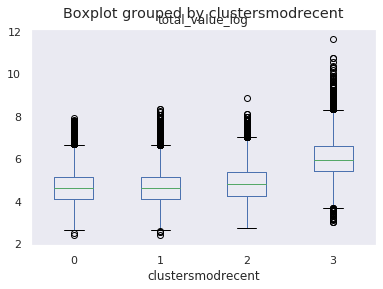

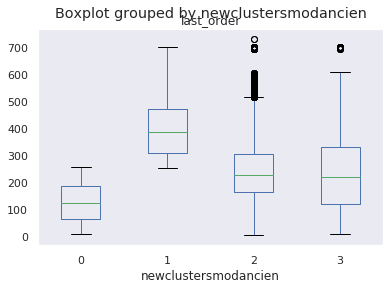

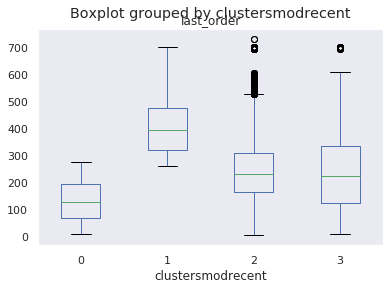

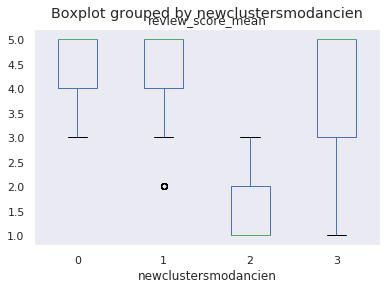

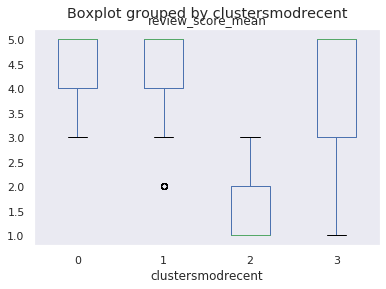

Différences :  {0: 0, 1: 1502, 2: 251, 3: 41}
Différence entre les données séparées de 0.5 mois : 1.8801286955428165  %
Différences cluster  0  =  0.0
Différences cluster  1  =  4.824617756649107
Différences cluster  2  =  1.675903051345396
Différences cluster  3  =  0.37694217155465665

 Data jusqu'à 2018-08-04 00:00:00
Data_final :  90307
Fin agg data
total_value          69.126905
nb_orders            15.673709
last_order            0.469885
review_score_mean    -1.343474
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders             1.000000
last_order           87.000000
review_score_mean     5.000000
total_value_log       4.962145
nb_orders_log         0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [1 0 3 2]
Composition du fichier complet avec clusters
last_order                  188
review_sc

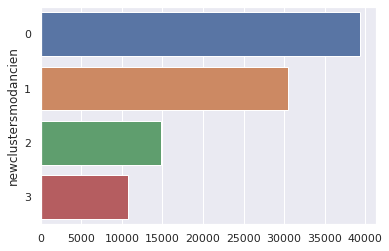

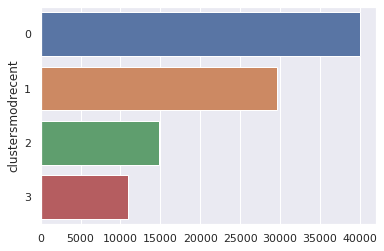

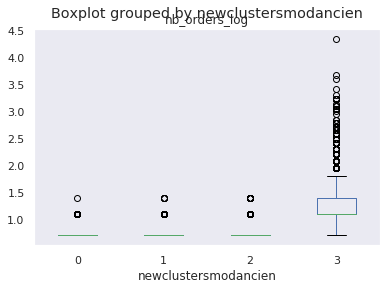

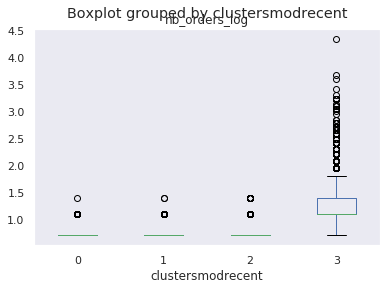

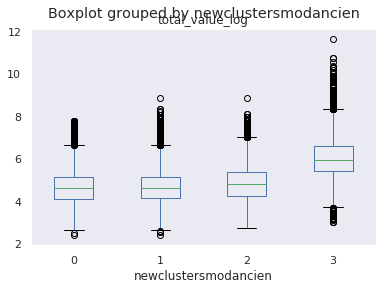

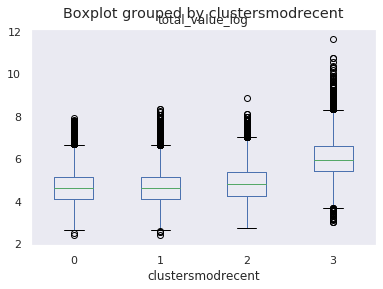

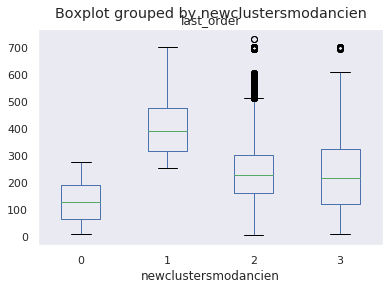

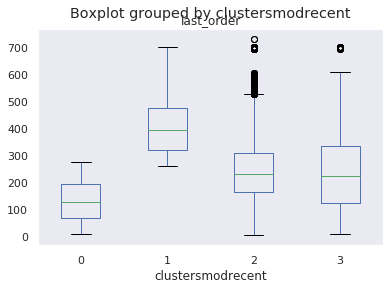

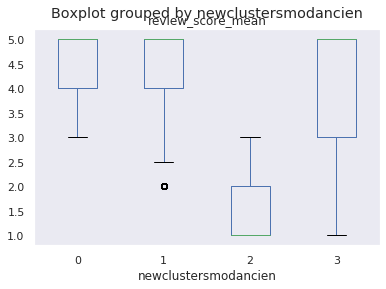

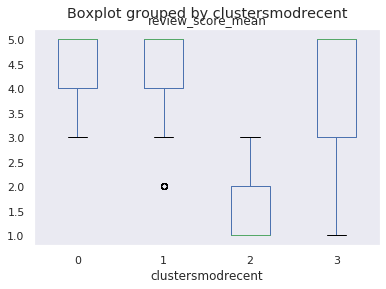

Différences :  {0: 2, 1: 911, 2: 219, 3: 66}
Différence entre les données séparées de 1.0 mois : 1.2555151489745229  %
Différences cluster  0  =  0.005088929034884609
Différences cluster  1  =  2.9828754788644773
Différences cluster  2  =  1.4769355273806313
Différences cluster  3  =  0.6140106056377337

 Data jusqu'à 2018-07-20 00:00:00
Data_final :  86620
Fin agg data
total_value          69.473845
nb_orders            15.872869
last_order            0.493267
review_score_mean    -1.332798
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders             1.000000
last_order           72.000000
review_score_mean     5.000000
total_value_log       4.962145
nb_orders_log         0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [2 1 3 0]
Composition du fichier complet avec clusters
last_order              

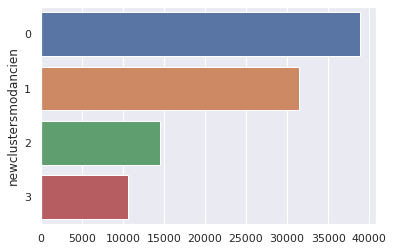

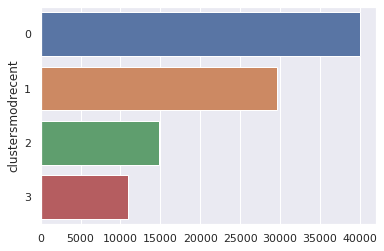

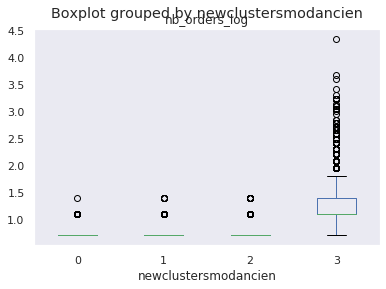

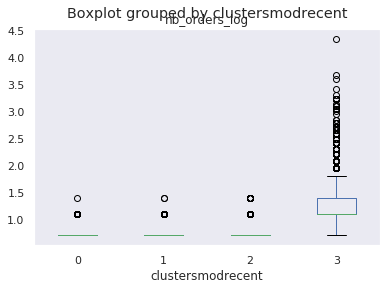

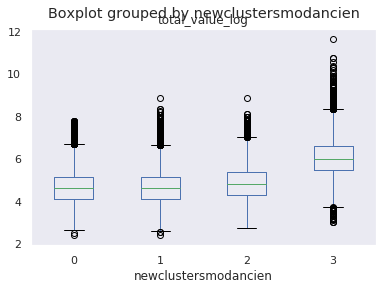

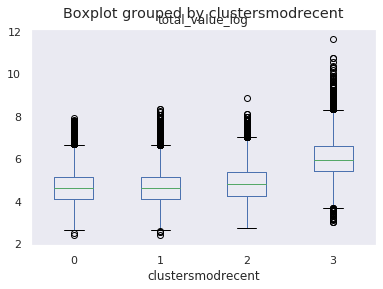

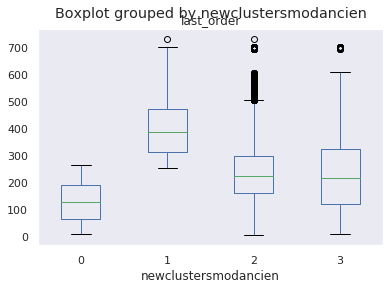

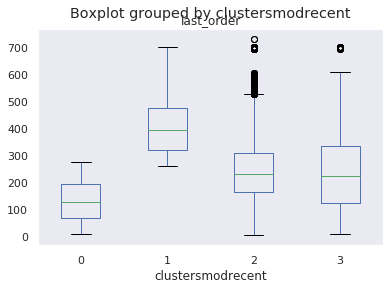

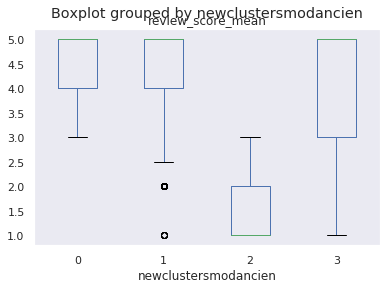

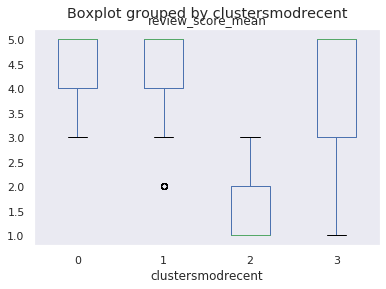

Différences :  {0: 11, 1: 1776, 2: 153, 3: 61}
Différence entre les données séparées de 1.5 mois : 2.097066621951603  %
Différences cluster  0  =  0.028330071082723805
Différences cluster  1  =  5.654970387823983
Différences cluster  2  =  1.0529938059187887
Différences cluster  3  =  0.5725011731581418

 Data jusqu'à 2018-07-05 00:00:00
Data_final :  84120
Fin agg data
total_value          70.853801
nb_orders            15.974577
last_order            0.511070
review_score_mean    -1.326325
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders             1.000000
last_order           57.000000
review_score_mean     5.000000
total_value_log       4.962145
nb_orders_log         0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [3 0 2 1]
Composition du fichier complet avec clusters
last_order              

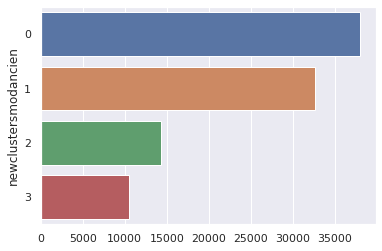

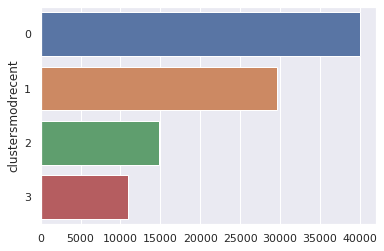

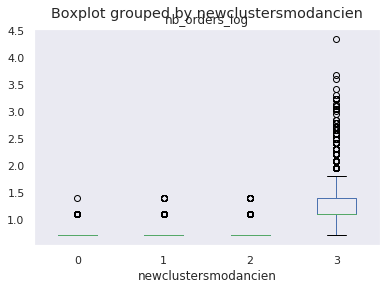

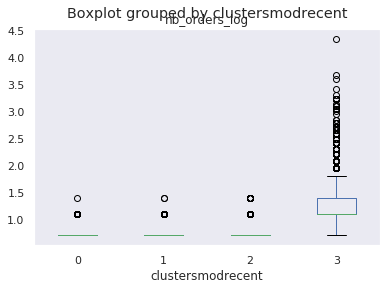

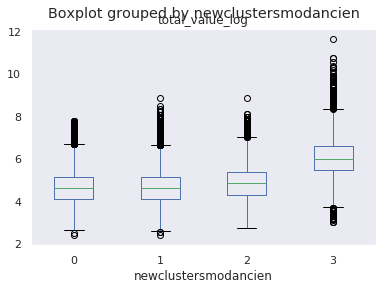

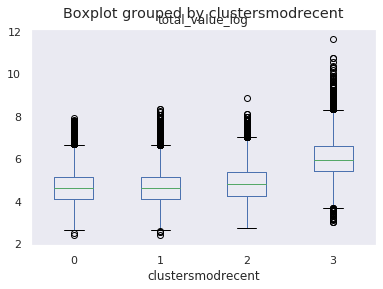

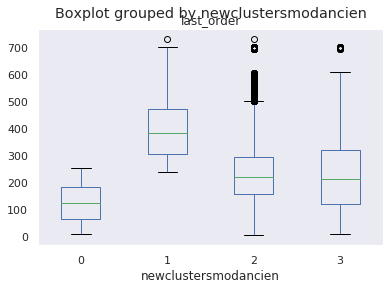

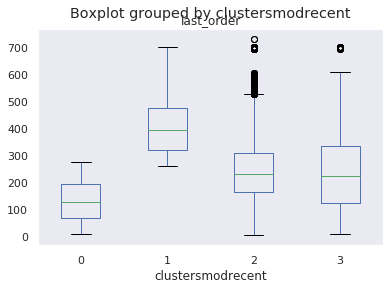

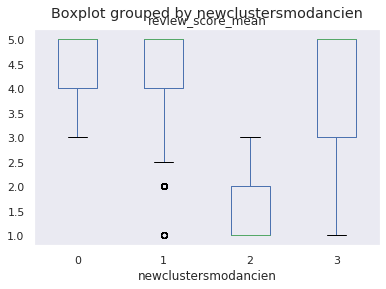

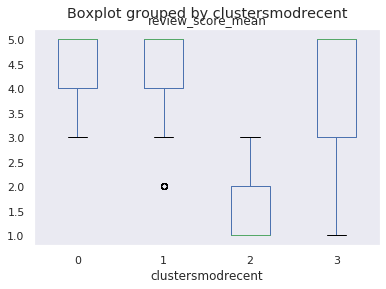

Différences :  {0: 12, 1: 2993, 2: 224, 3: 77}
Différence entre les données séparées de 2.0 mois : 3.4647187667026484  %
Différences cluster  0  =  0.03164890811267011
Différences cluster  1  =  9.174508782147564
Différences cluster  2  =  1.562718013115669
Différences cluster  3  =  0.7301346482078512

 Data jusqu'à 2018-06-20 00:00:00
Data_final :  81193
Fin agg data
total_value          71.466204
nb_orders            16.156889
last_order            0.527094
review_score_mean    -1.312624
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders             1.000000
last_order           42.000000
review_score_mean     5.000000
total_value_log       4.962145
nb_orders_log         0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [0 3 2 1]
Composition du fichier complet avec clusters
last_order               

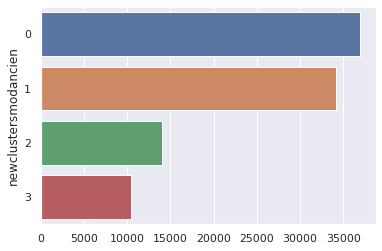

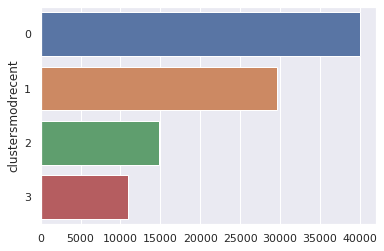

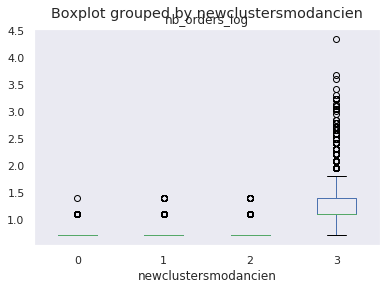

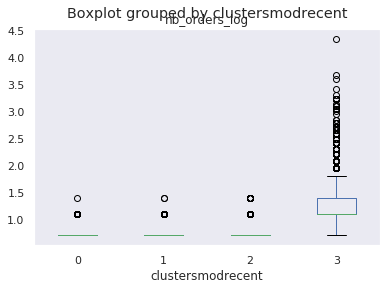

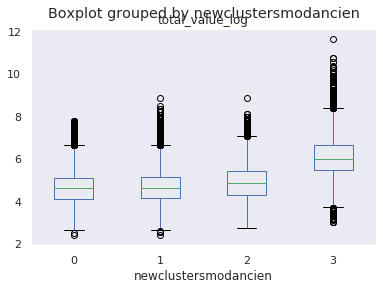

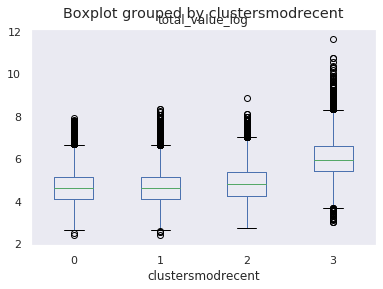

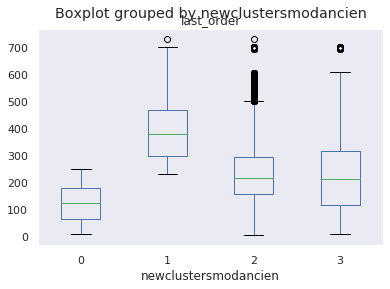

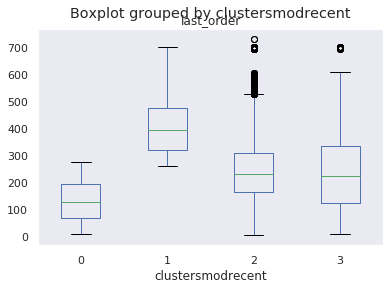

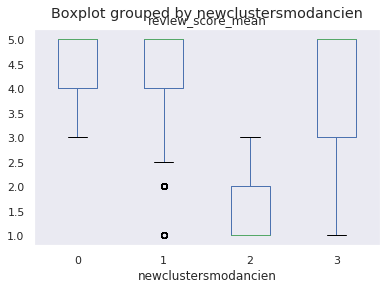

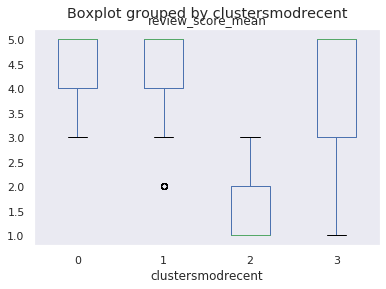

Différences :  {0: 30, 1: 4480, 2: 198, 3: 94}
Différence entre les données séparées de 2.5 mois : 5.032540688961317  %
Différences cluster  0  =  0.08132505624983057
Différences cluster  1  =  13.133978305482263
Différences cluster  2  =  1.4162077104642015
Différences cluster  3  =  0.9004693936200785

 Data jusqu'à 2018-06-05 00:00:00
Data_final :  78090
Fin agg data
total_value          71.687010
nb_orders            16.414171
last_order            0.543083
review_score_mean    -1.299499
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders             1.000000
last_order           27.000000
review_score_mean     5.000000
total_value_log       4.962145
nb_orders_log         0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [1 0 2 3]
Composition du fichier complet avec clusters
last_order              

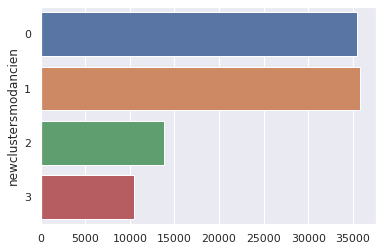

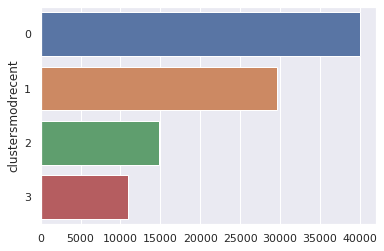

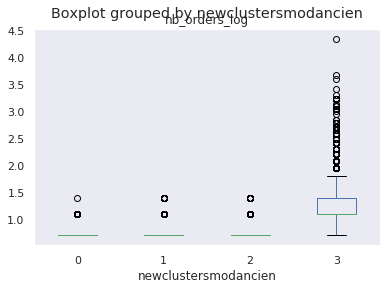

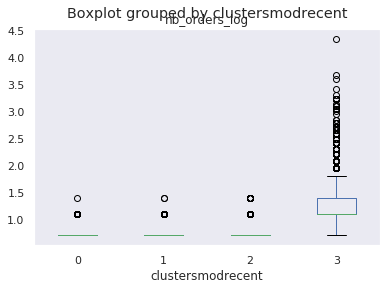

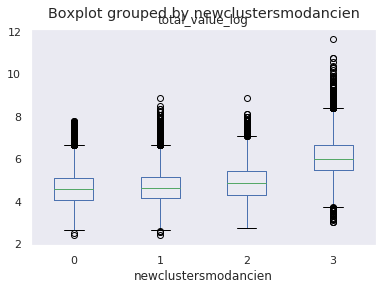

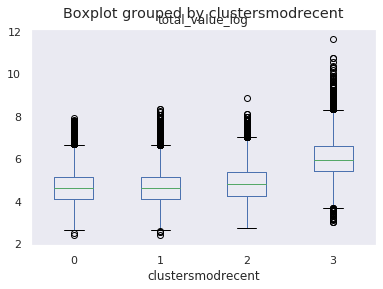

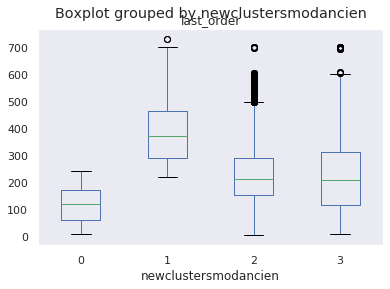

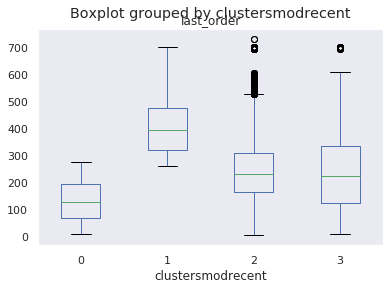

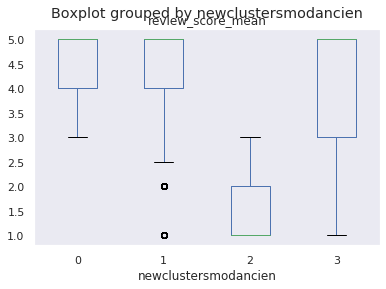

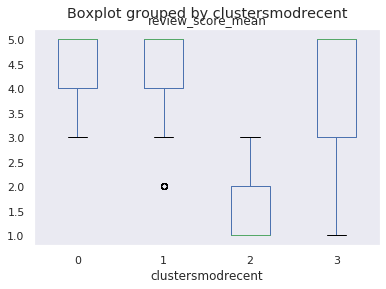

Différences :  {0: 17, 1: 6118, 2: 230, 3: 124}
Différence entre les données séparées de 3.0 mois : 6.800532388727612  %
Différences cluster  0  =  0.04789676837686304
Différences cluster  1  =  17.114244153519078
Différences cluster  2  =  1.6701764577735823
Différences cluster  3  =  1.1915057173056596

 Data jusqu'à 2018-05-21 00:00:00
Data_final :  75943
Fin agg data
total_value          74.305406
nb_orders            16.585169
last_order            0.550804
review_score_mean    -1.289070
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders             1.000000
last_order           12.000000
review_score_mean     5.000000
total_value_log       4.962145
nb_orders_log         0.693147
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [0 2 1 3]
Composition du fichier complet avec clusters
last_order             

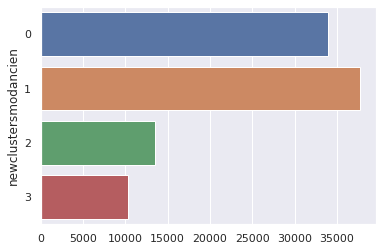

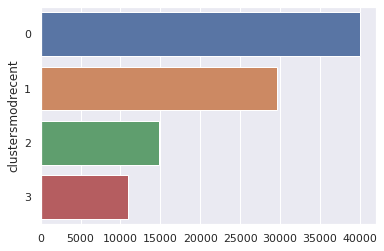

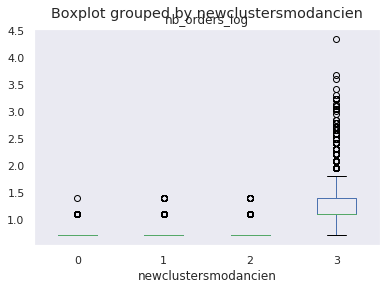

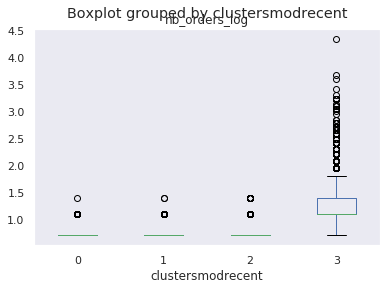

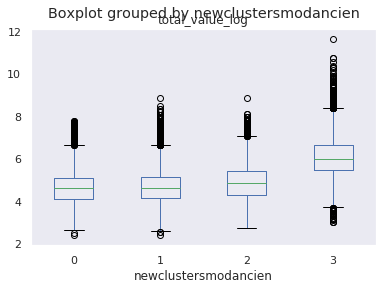

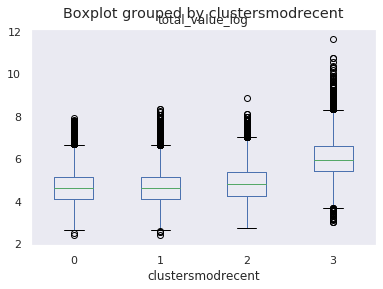

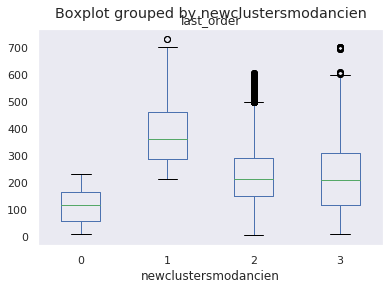

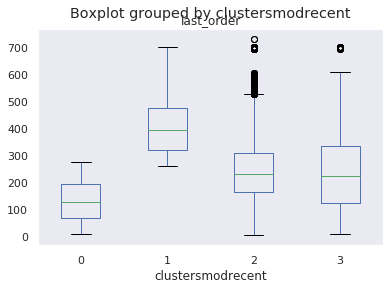

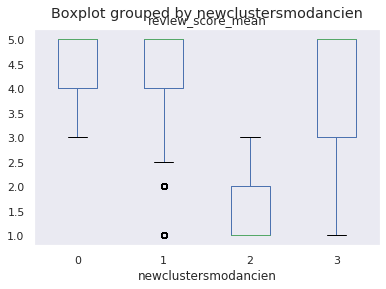

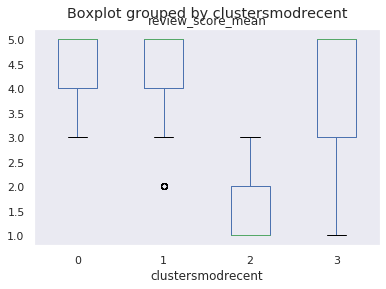

Différences :  {0: 18, 1: 8027, 2: 240, 3: 155}
Différence entre les données séparées de 3.5 mois : 8.845198545363083  %
Différences cluster  0  =  0.053019145802650956
Différences cluster  1  =  21.316089969992298
Différences cluster  2  =  1.7834584231255108
Différences cluster  3  =  1.496861419604056

 Data jusqu'à 2018-05-06 00:00:00
Data_final :  72062
Fin agg data
total_value          74.945517
nb_orders            16.880983
last_order            0.555952
review_score_mean    -1.279699
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders              1.000000
last_order           423.000000
review_score_mean      3.000000
total_value_log        4.468434
nb_orders_log          0.693147
Name: 0000f46a3911fa3c0805444483337064, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [0 3 2 1]
Composition du fichier complet avec clusters
last_order        

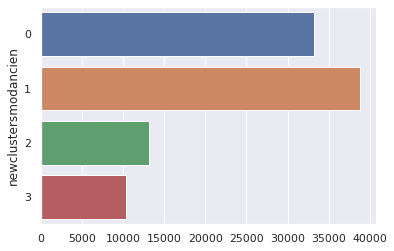

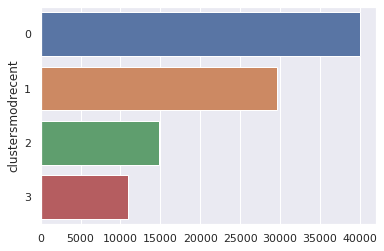

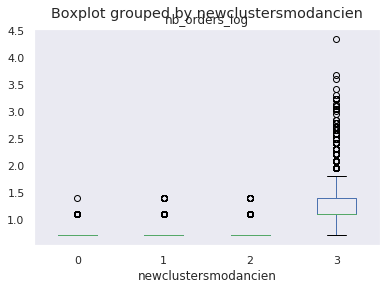

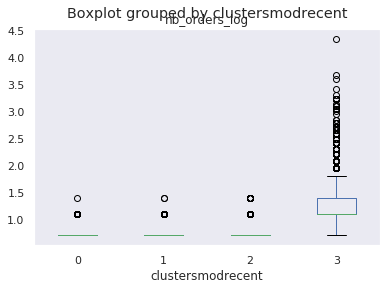

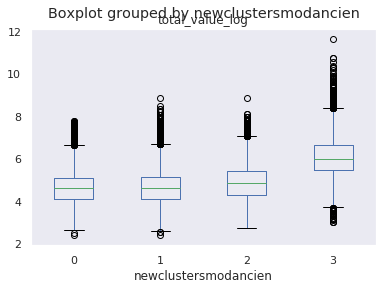

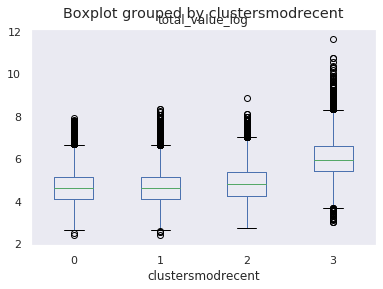

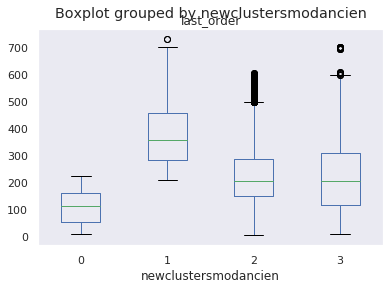

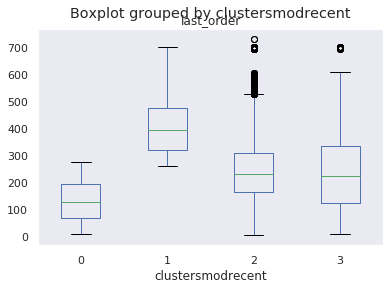

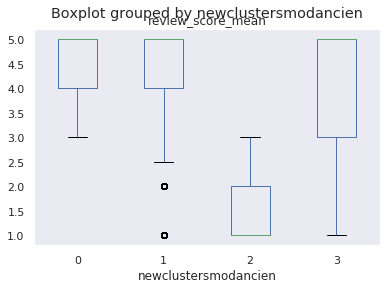

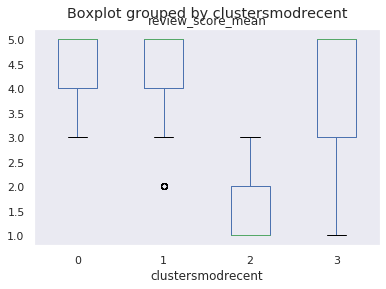

Différences :  {0: 7, 1: 9113, 2: 272, 3: 173}
Différence entre les données séparées de 4.0 mois : 10.024209014976053  %
Différences cluster  0  =  0.021095139077238343
Différences cluster  1  =  23.52166843042614
Différences cluster  2  =  2.062793872288791
Différences cluster  3  =  1.6784709420781994

 Data jusqu'à 2018-04-21 00:00:00
Data_final :  68544
Fin agg data
total_value          74.934568
nb_orders            17.220651
last_order            0.563228
review_score_mean    -1.266458
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders              1.000000
last_order           408.000000
review_score_mean      3.000000
total_value_log        4.468434
nb_orders_log          0.693147
Name: 0000f46a3911fa3c0805444483337064, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [0 2 3 1]
Composition du fichier complet avec clusters
last_order         

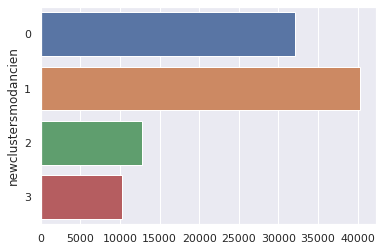

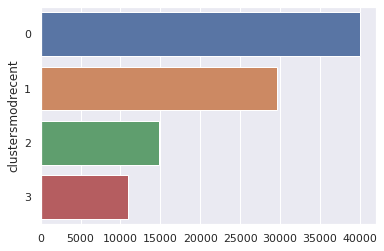

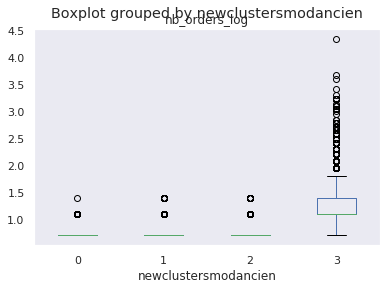

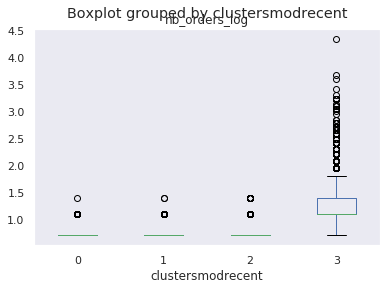

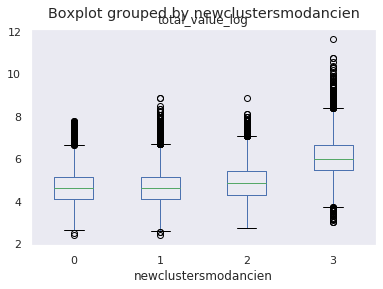

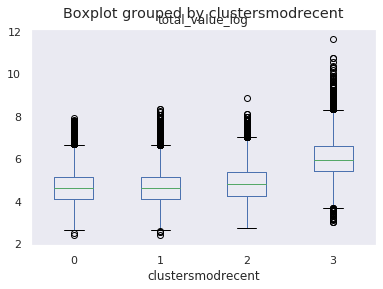

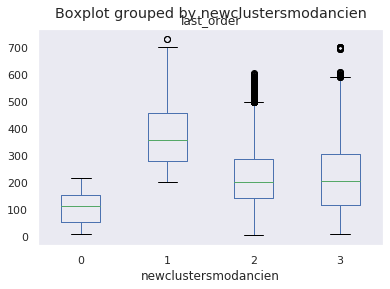

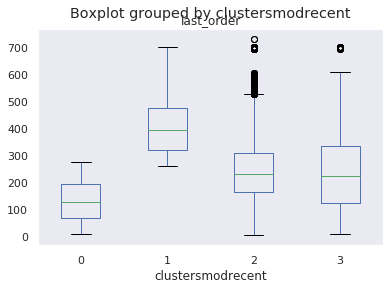

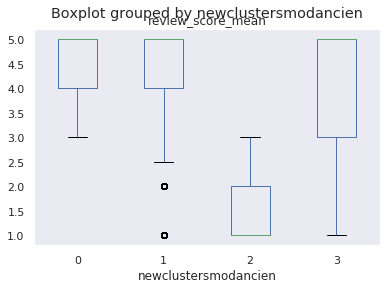

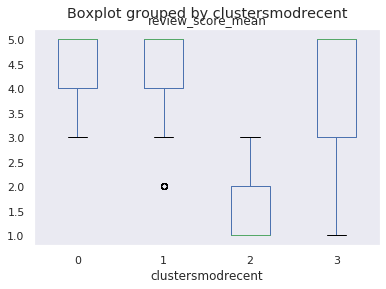

Différences :  {0: 1, 1: 10614, 2: 297, 3: 199}
Différence entre les données séparées de 4.5 mois : 11.644431402550854  %
Différences cluster  0  =  0.0031136158420774045
Différences cluster  1  =  26.374117880926352
Différences cluster  2  =  2.3159700561447285
Différences cluster  3  =  1.944498729724448

 Data jusqu'à 2018-04-06 00:00:00
Data_final :  65283
Fin agg data
total_value          77.313206
nb_orders            17.578018
last_order            0.568518
review_score_mean    -1.256613
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders              1.000000
last_order           393.000000
review_score_mean      3.000000
total_value_log        4.468434
nb_orders_log          0.693147
Name: 0000f46a3911fa3c0805444483337064, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [1 3 0 2]
Composition du fichier complet avec clusters
last_order      

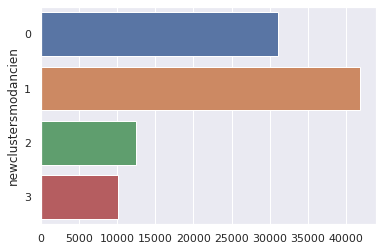

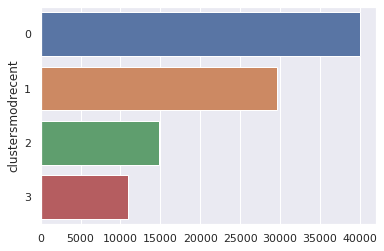

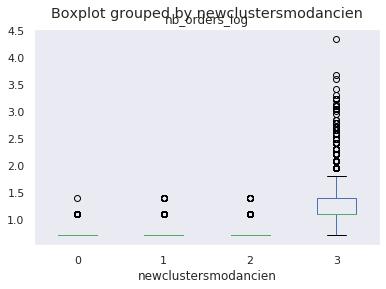

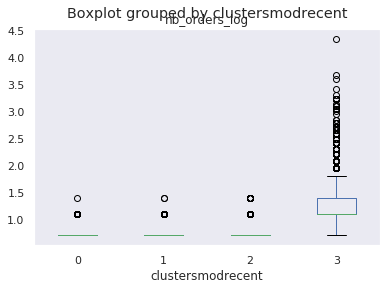

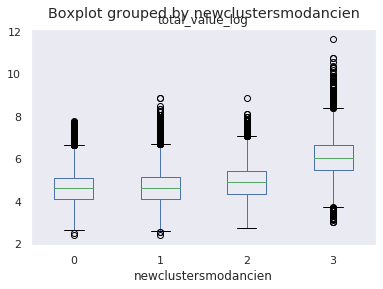

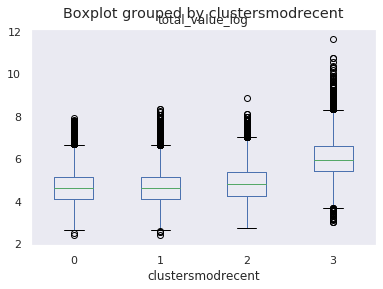

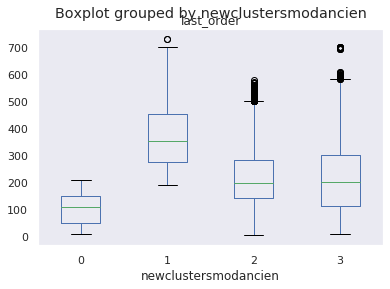

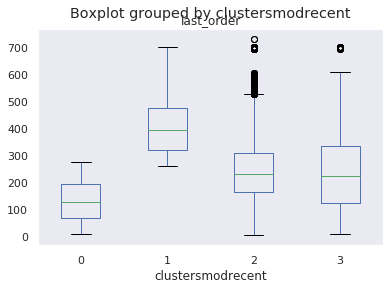

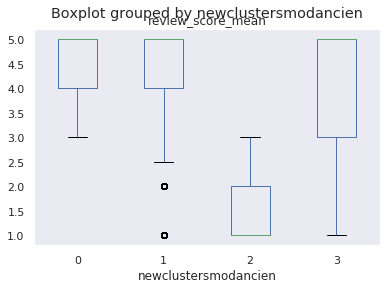

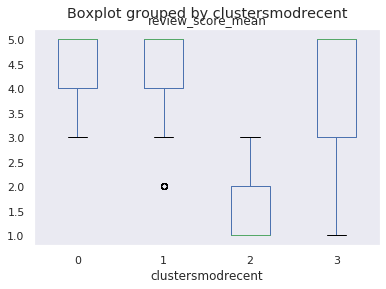

Différences :  {0: 0, 1: 12126, 2: 372, 3: 257}
Différence entre les données séparées de 5.0 mois : 13.367358702145275  %
Différences cluster  0  =  0.0
Différences cluster  1  =  29.040137944247533
Différences cluster  2  =  2.9850746268656714
Différences cluster  3  =  2.527040314650934

 Data jusqu'à 2018-03-22 00:00:00
Data_final :  62100
Fin agg data
total_value          77.667904
nb_orders            17.885760
last_order            0.570359
review_score_mean    -1.257439
dtype: float64
Index(['nb_orders', 'last_order', 'review_score_mean', 'total_value_log',
       'nb_orders_log'],
      dtype='object')
nb_orders              1.000000
last_order           378.000000
review_score_mean      3.000000
total_value_log        4.468434
nb_orders_log          0.693147
Name: 0000f46a3911fa3c0805444483337064, dtype: float64
Fin préparation
Composition du fichier partiel
Correspondance des clusters :  [1 0 3 2]
Composition du fichier complet avec clusters
last_order                  188
re

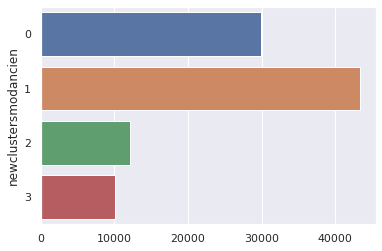

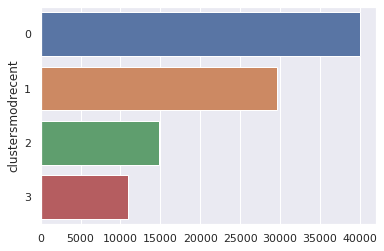

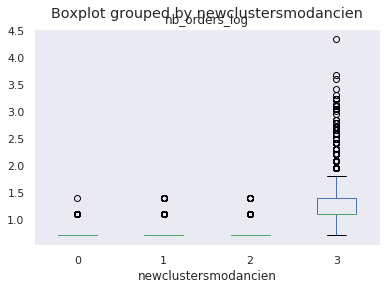

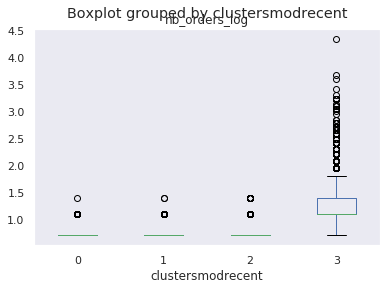

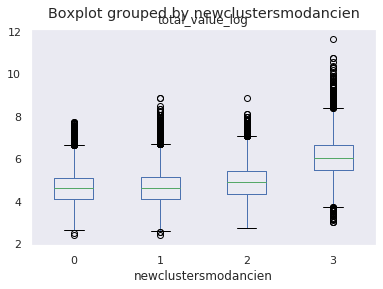

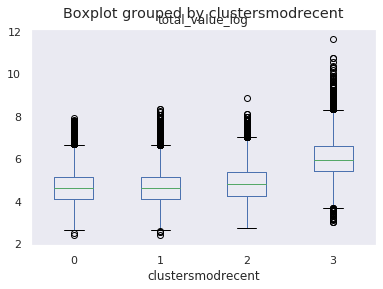

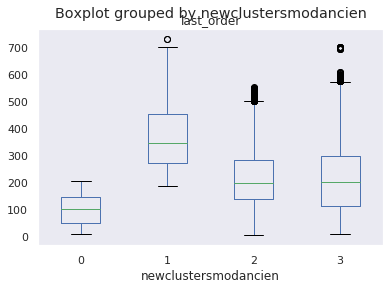

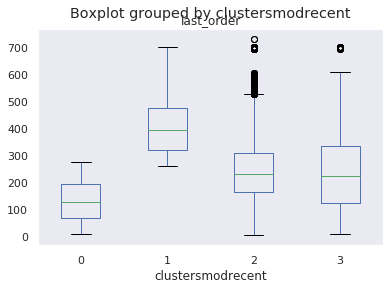

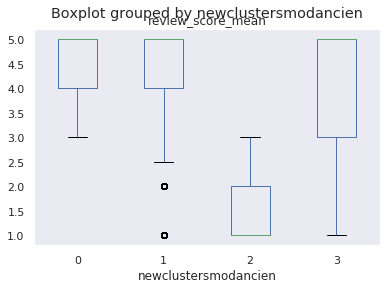

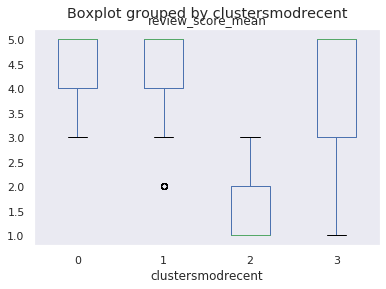

Différences :  {0: 0, 1: 13645, 2: 403, 3: 271}
Différence entre les données séparées de 5.5 mois : 15.006445257233883  %
Différences cluster  0  =  0.0
Différences cluster  1  =  31.530906990179087
Différences cluster  2  =  3.320425146247014
Différences cluster  3  =  2.6970541401273884


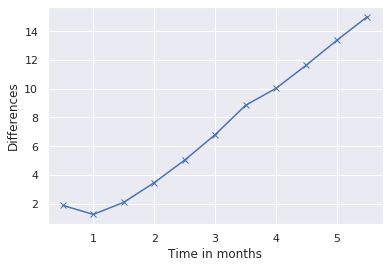

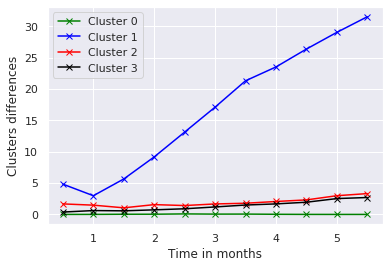

In [0]:
intervalle = timedelta(days=15)
date = integral_data['order_purchase_timestamp_date'].max()
print ("Date la plus récente :", date)
datavar2 = calcul_var(integral_data, date)

masque = datavar2["nb_orders"] >= 2
print ("Masque fait")
multiple_orders = datavar2[masque]
multiple_order = multiple_orders.index.values[0]
simple_order = datavar2.index.values[0]
test = [multiple_order, simple_order]
print (test)
datavar2.drop(["nb_orders"], axis=1, inplace=True)
print ("Composition du fichier complet")
print_test(datavar2, test)

X_2 = preparation_X(datavar2)
X_2 = complete_cluster(X_2)
print ("Colonnes du fichier total :", X_2.columns)

dates = []
dates.append(date)
for i in range(24):
    newdate = date - intervalle
    dates.append(newdate)
    date = newdate

X_graph = []
Y_graph = []
graph = {}

for t in range(len(dates)-1):
    print ("\n Data jusqu'à", dates[1+t])
    data1 = filtre_data(integral_data, dates[1+t])
    datavar1 = calcul_var(data1, dates[1+t])
    datavar1.drop(["nb_orders"], axis=1, inplace=True)
    X_1 = preparation_X(datavar1)
    print ("Composition du fichier partiel")
    difference, diff, comp = differences(X_1, X_2)
    print ("Différences : ", diff)
    timeinter = ((15*t)/30)+0.5
    print ("Différence entre les données séparées de", timeinter, "mois :",
           difference, " %")
    for i in range(4):
        diff_cluster = (diff[i]/comp[i])*100
        print ("Différences cluster ", i, " = ", diff_cluster)
        if (str(i) in graph):
            graph[str(i)].append(diff_cluster)
        else:
            graph[str(i)] = []
            graph[str(i)].append(diff_cluster)
    X_graph.append(timeinter)
    Y_graph.append(difference)
    if (difference >= 15):
        break

sns.set()
plt.plot(X_graph, Y_graph, 'bx-')
plt.ylabel('Differences')
plt.xlabel('Time in months')
plt.show()

sns.set()
plt.plot(X_graph, graph["0"], 'bx-', color='green', label='Cluster 0')
plt.plot(X_graph, graph["1"], 'bx-', color='blue', label='Cluster 1')
plt.plot(X_graph, graph["2"], 'bx-', color='red', label='Cluster 2')
plt.plot(X_graph, graph["3"], 'bx-', color='black', label='Cluster 3')
plt.legend()
plt.ylabel('Clusters differences')
plt.xlabel('Time in months')
plt.show()
